# Pipeline Exploration
This project workflow is comprised of distinct stages including: 

1. Universe Definition
2. Alpha Discovery

In [2]:
import pyfolio as pf

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
load_data = True
if load_data:
    print ('ready to load data from quandl')

ready to load data from quandl


In [4]:
import alphalens as al

In [5]:
import quandl
import quantstats as qs
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
from sklearn import preprocessing
import pytz
import itertools

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
import risk_model
import factorize
import account
import utils_s
import feature_weights

In [8]:
import zipfile
import os

In [9]:
quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'

# 1 - Parameters

## 1 - 1 - Date parameters

In [10]:
tod = datetime.datetime.today().date()
print ('current date: {}'.format(tod))
fivedays_ago = tod - datetime.timedelta(days=5)
#fivedays_ago = datetime.datetime.strptime(str(fivedays_ago), '%Y-%m-%d').strftime("%Y-%m-%d")
print ('5 days ago: {}'.format(fivedays_ago))
year_ago = tod - datetime.timedelta(days=365)
#t_ago = datetime.datetime.strptime(str(t_ago), '%Y-%m-%d').strftime("%Y-%m-%d")
print ('12 months ago: {}'.format(year_ago))

current date: 2020-06-28
5 days ago: 2020-06-23
12 months ago: 2019-06-29


In [11]:
# SF1
three_years = str(tod.year - 4)
month = str(tod.month)
day = str(tod.day)
start_f = '{}-{}-{}'.format(three_years,month,day)
print ('SF1 starting date: {}'.format(start_f))

SF1 starting date: 2016-6-28


In [12]:
# SEP & daily
two_years = str(tod.year - 3)
month = str(tod.month)
day = str(tod.day)
start_sep = '{}-{}-{}'.format(two_years,month,day)
print ('SEP and Daily starting date: {}'.format(start_sep))

SEP and Daily starting date: 2017-6-28


## 1 - 2 - Universe filteration parameters

In [13]:
filteration_number  = 200
smoothing_universe_period = 100

## 1 - 3 - Slicing date parameter

In [14]:
# Slicing data for 1y
years_to_slice = 1
year = str(tod.year - years_to_slice)
month = str(tod.month)
day = str(tod.day)
ayear = '{}-{}-{}'.format(year,month,day)

start = ayear
end = str(tod)
print ('Final slicing date for {} year: {}'.format(years_to_slice,ayear))

Final slicing date for 1 year: 2019-6-28


## 1 - 4 - Multi factor analysis parameters

In [15]:
rebalance_period = 5
combined_periods = (3,5,10)

In [16]:
# Risk analysis
factor_exposures = 13

## 1 - 5 - Optimizer parameters

In [17]:
lambda_reg = 0.5
risk_cap = 0.05

## 1 - 6 - Sectors to drop

In [18]:
sec_to_drop = [  
               'Basic Materials',
               'Communication Services'
              ]

## 1 - 7 - MarketCap categories

In [19]:
cap_select = ['6 - Mega', '5 - Large', '4 - Mid']

## 1 - 8 - Factors

In [20]:
smoothed_value = 5

In [21]:
selected_indicators = ['cashneq']

In [22]:
momentum_in = {'momentum_252d':252}

In [23]:
sma_in = {'sma200':200}

In [24]:
daily_in = {'marketcap':100, 'evebitda':100}

In [25]:
over_in = {'overnight_sentiment_5d':5}

In [26]:
direction_in = {'direction_100d':100}

In [27]:
sent_in = {'sentiment_100d':100}

# 2 - Data processing

## 2 - 1 - Get  META data

In [28]:
meta = quandl.get_table('SHARADAR/TICKERS', table='SF1',paginate=True)
meta.set_index('ticker',inplace=True, drop=True)

## 2 - 1 - 1 - First universe filteration

In [29]:
meta_ex = meta[(meta['exchange'] == 'NYSE') ^ (meta['exchange'] == 'NASDAQ')]
cap = []
for i in cap_select:
    cap.append(list(meta_ex[(meta_ex['scalemarketcap'] == i)].index))
meta_ex_sc = meta_ex.loc[list(itertools.chain.from_iterable(cap))]    
meta_ex_sc_cu = meta_ex_sc[(meta_ex_sc['currency'] == 'USD') & (meta_ex_sc['isdelisted'] == 'N')]

In [30]:
u1 = list(meta_ex_sc_cu.index)

In [31]:
print ('{} companies selected in first filteration'.format(len(u1)))

1991 companies selected in first filteration


## 2 - 2 - Get two years data for SEP

In [32]:
if load_data:
    quandl.export_table('SHARADAR/SEP',
                        ticker=u1, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename = 'ohlcv.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
ohlcv.zip


In [33]:
with zipfile.ZipFile('ohlcv.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SEP':
        
        ohlcv = pd.read_csv(item)
        ohlcv['date'] = pd.to_datetime(ohlcv['date'])
        ohlcv = ohlcv.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        ohlcv.drop(['lastupdated','dividends','closeunadj'],axis=1,inplace=True)

        os.remove(item)

cleaning data
columns are clean


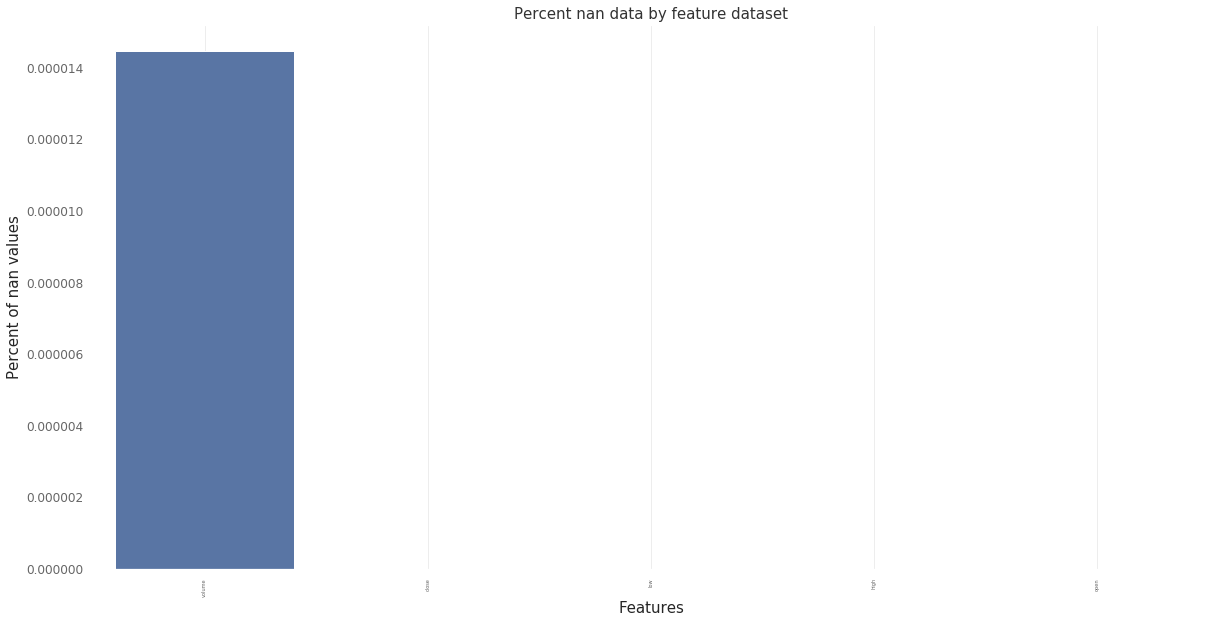

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [34]:
ohlcv = utils_s.cleaning_dataframe(ohlcv,0.2)

### 2 - 2 - 1 - Second universe filteration using Market Capitalization 

In [35]:
def dollar_volume_universe(tickers_num, ohlcv, sma_period):
    
    ohlcv['dollar_volume'] = ohlcv['close']*ohlcv['volume']
    dollar_vol = ohlcv['dollar_volume'].unstack('ticker')
    sma = pd.DataFrame(index = dollar_vol.index)
    try:
        for tick in dollar_vol.columns:
            sma[tick] = talib.SMA(dollar_vol[tick].values, timeperiod=sma_period)
    except:
        pass
    
    last = sma.iloc[-1,:]
    dol = pd.DataFrame(data = last.values,index = last.index, columns = ['dv'])
    dol.dropna(inplace = True)
    
    return list(dol.sort_values(by='dv', ascending=False).iloc[:tickers_num].index)    

In [36]:
universe = dollar_volume_universe(tickers_num = filteration_number, ohlcv = ohlcv, sma_period = smoothing_universe_period)

In [37]:
print ('{} companies selected out of {} for second filteration'.format(len(universe),len(u1)))

200 companies selected out of 1991 for second filteration


#### Sector filteration

In [38]:
universe_sectors = pd.DataFrame(index=universe, columns=['sectors'])
for i in universe:
    universe_sectors.loc[i] = meta_ex_sc_cu.loc[i]['sector']
    
    for sec in sec_to_drop:
        if meta_ex_sc_cu.loc[i]['sector'] == sec:
            universe_sectors.drop(i, axis=0,inplace=True)

In [39]:
universe = list(universe_sectors.index)

In [40]:
print ('{} companies selected after sector drop out of {} for second filteration'.format(len(universe),len(u1)))

190 companies selected after sector drop out of 1991 for second filteration


## 2 - 3 - Get three years data for SF1

In [41]:
if load_data:
    #qopts={"columns":ind}
    quandl.export_table('SHARADAR/SF1',
                        ticker=universe, 
                        dimension = 'MRQ', 
                        calendardate={'gte':start_f,'lte':str(tod)}, 
                        filename='fundamental.zip')

We are generating the zip file now, please wait...
fundamental.zip


In [42]:
with zipfile.ZipFile('fundamental.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'SF1':
        sf1 = pd.read_csv(item)
        sf1 = sf1.set_index(['calendardate', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sf1.drop(['datekey','reportperiod','lastupdated','dimension'],axis=1,inplace=True)
        os.remove(item)  

In [43]:
print ('the following tickers are not loaded in sf1:\n {}'.format(list(sf1.index.levels[1] ^ universe)))
print ('{} securities loaded out of {}'.format(len(sf1.index.levels[1]), len(universe)))

the following tickers are not loaded in sf1:
 ['BP']
189 securities loaded out of 190


### 2 - 3 - 1 - Cleaning data

cleaning data
columns are clean


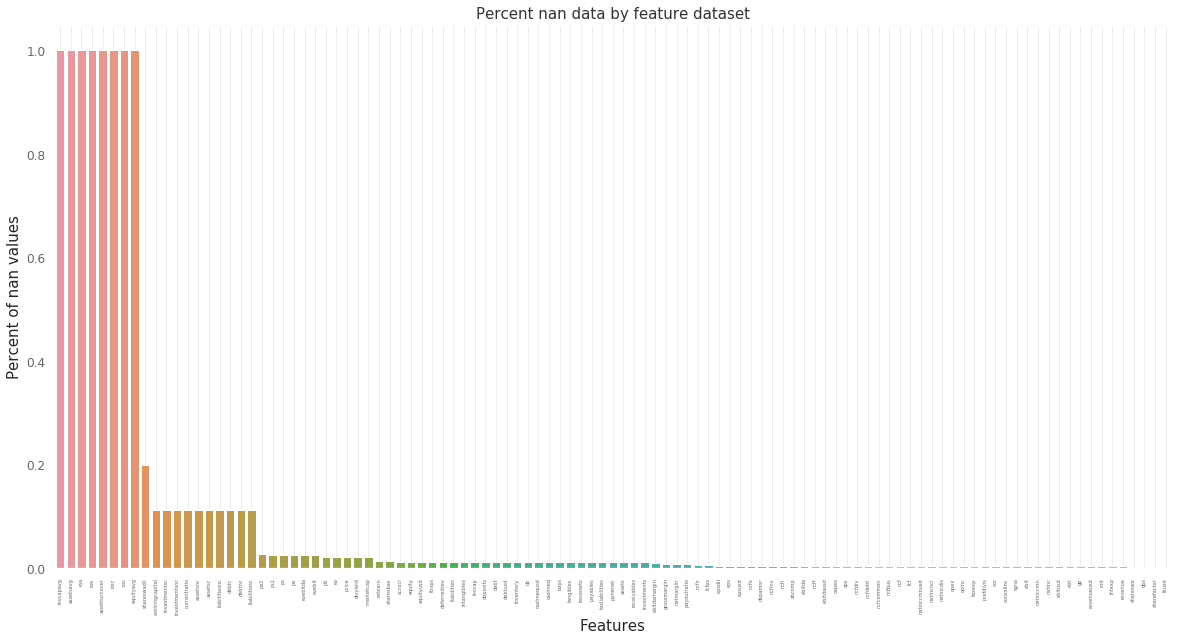

The percentage of dropped columns is 7%.
Dropped 8 columns out of 105


In [44]:
sf1 = utils_s.cleaning_dataframe(sf1,0.2)

In [45]:
sf1['roe'] = sf1['netinc'] / sf1['equity']
sf1['roa'] = sf1['netinc'] / sf1['assets']
sf1['fcf_yield'] = sf1['fcf'] / sf1['ev']

## 2 - 4 - Get two years data for DAILY

In [46]:
if load_data:
    quandl.export_table('SHARADAR/DAILY',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='daily.zip')

We are generating the zip file now, please wait...
daily.zip


In [47]:


with zipfile.ZipFile('daily.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'SHARADAR' and item.split('_')[1] == 'DAILY':
        daily = pd.read_csv(item)
        daily['date'] = pd.to_datetime(daily['date'])
        daily = daily.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        daily.drop(['lastupdated'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


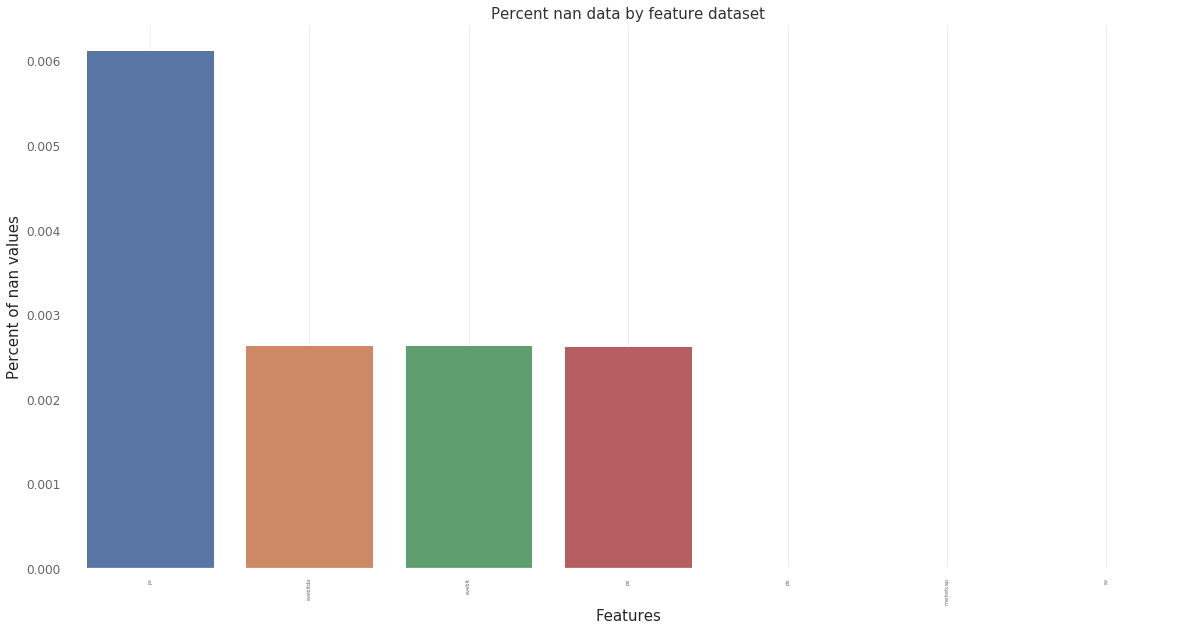

The percentage of dropped columns is 0%.
Dropped 0 columns out of 7


In [48]:
daily = utils_s.cleaning_dataframe(daily,0.2)

## 2 - 4 - Get two years data for SENTIMENT

In [49]:
if load_data:
    quandl.ApiConfig.api_key = 'WW4cUYaXdyxgjvdu4z9s'
    quandl.export_table('IFT/NSA',
                        ticker=universe, 
                        date={'gte': start_sep, 'lte': str(tod)}, 
                        filename='sent.zip')

We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
We are generating the zip file now, please wait...
sent.zip


In [50]:
with zipfile.ZipFile('sent.zip', 'r') as zip_ref:
    zip_ref.extractall()

for item in os.listdir(os.getcwd()):  # loop through items in dir
    
    if item.endswith('.csv') and item.split('_')[0] == 'IFT' and item.split('_')[1] == 'NSA':
        sent = pd.read_csv(item)
        sent['date'] = pd.to_datetime(sent['date'])
        sent = sent.set_index(['date', 'ticker']).sort_index(level=[0,1], ascending=[True, False])
        sent = sent[sent['exchange_cd']=='US']
        sent.drop(['name','exchange_cd'],axis=1,inplace=True)
        os.remove(item) 

cleaning data
columns are clean


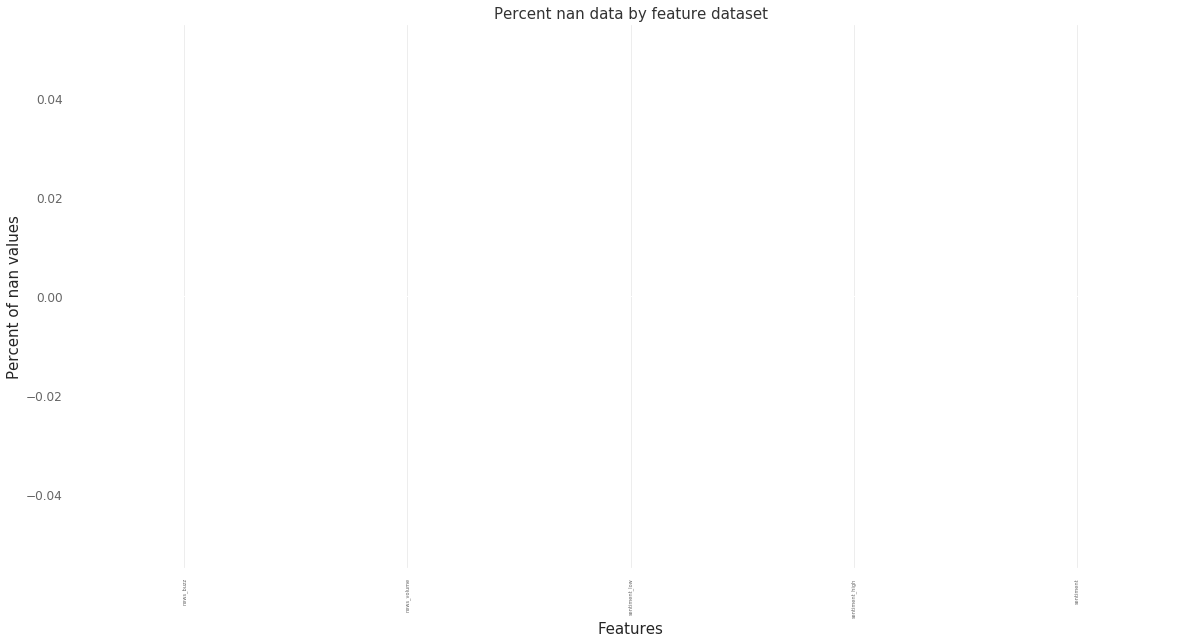

The percentage of dropped columns is 0%.
Dropped 0 columns out of 5


In [51]:
sent = utils_s.cleaning_dataframe(sent,0.2)

### Universe intersection

In [52]:
inter1 = set(sent['sentiment'].unstack('ticker').columns).intersection(set(sf1.index.levels[1]))
inter2 = inter1.intersection(set(daily.index.levels[1]))
new_universe = list(inter2)

In [53]:
len(new_universe)

180

# 3 - Sectors

In [54]:
meta_cleaned = meta_ex_sc_cu.loc[new_universe,:]

In [55]:
print ('Sectors in filtered data: \n')
sectors = {}
for i in set(meta_cleaned['sector']):
    print (' ',i)
    sectors[i] = list(meta_cleaned[meta_cleaned['sector'] == i].index)

Sectors in filtered data: 

  Healthcare
  Utilities
  Energy
  Technology
  Consumer Cyclical
  Consumer Defensive
  Financial Services
  Real Estate
  Industrials


# 4 - Factorizing, Neutralizing and Resampling 

## 4 - 1 - Factorizing

In [56]:
close = ohlcv['close'].unstack('ticker')[new_universe]
openn = ohlcv['open'].unstack('ticker')[new_universe]
high = ohlcv['high'].unstack('ticker')[new_universe]
low = ohlcv['low'].unstack('ticker')[new_universe]

In [57]:
#close.to_csv('close.csv')

In [58]:
pricing = openn.loc[slice(start,end),:].tz_localize('UTC')[new_universe]

In [59]:
# daily

daily_data = {}

for i in daily_in.keys():
    
    df_daily = daily[i].unstack('ticker')
    reversion = factorize.Momentum(df_daily,daily_in[i])*-1
    smoothed_reversion = factorize.Smooth(reversion,smoothed_value)
    smoothed_reversion.index = pd.to_datetime(smoothed_reversion.index)
    smoothed_reversion = smoothed_reversion.loc[slice(start,end),:]

    result = []
    for sec in sectors.keys():
        result.append(smoothed_reversion[sectors[sec]].sub(smoothed_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_reversion_neutralized = pd.concat(result,axis=1)
    smoothed_reversion_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_reversion_neutralized),
                                                         index = smoothed_reversion_neutralized.index,
                                                         columns = smoothed_reversion_neutralized.columns)
    
    daily_data[i] = smoothed_reversion_neutralized_scaled


In [60]:
# SMA
sma_data = {}

for name,period in sma_in.items():

    df= pd.DataFrame(index = close.index)

    try:
        for tick in close.columns:
            df[tick] = talib.SMA(close[tick].values, timeperiod=period)
    except:
        pass

    sma_min = (close - df)*-1
    smoothed_sma_min = factorize.Smooth(sma_min,smoothed_value)
    smoothed_sma_min.index = pd.to_datetime(smoothed_sma_min.index)
    smoothed_sma_min = smoothed_sma_min.loc[slice(start,end),:]
    
    # Neutralizing by sector
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sma_min[sectors[sec]].sub(smoothed_sma_min[sectors[sec]].mean(axis=1),axis=0))

    smoothed_sma_min_neutralized = pd.concat(result,axis=1)    
    
    smoothed_sma_min_neutralized_scaled = pd.DataFrame(data = preprocessing.scale(smoothed_sma_min_neutralized),
                                                              index = smoothed_sma_min_neutralized.index,
                                                              columns = smoothed_sma_min_neutralized.columns)
    
    sma_data[name] = smoothed_sma_min_neutralized_scaled
    

In [61]:
over_data = {}

for name,period in over_in.items():
    overnight_sentiment = factorize.overnight_sentiment(close, openn, window_length=1, trailing_window=period)*-1
    smoothed_overnight_sentiment = factorize.Smooth(overnight_sentiment,smoothed_value)
    
    smoothed_overnight_sentiment.index = pd.to_datetime(smoothed_overnight_sentiment.index)
    
    smoothed_overnight_sentiment = smoothed_overnight_sentiment.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_overnight_sentiment[sectors[sec]].sub(smoothed_overnight_sentiment[sectors[sec]].mean(axis=1),axis=0))

    smoothed_overnight_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    over_data[name] = smoothed_overnight_sentiment_neutralized_scaled
    

In [62]:
# mean reversion
momentum_data = {}

for name,period in momentum_in.items():
    
    mean_reversion = factorize.Momentum(close,period)*-1
    smoothed_mean_reversion = factorize.Smooth(mean_reversion,smoothed_value)
    
    smoothed_mean_reversion.index = pd.to_datetime(smoothed_mean_reversion.index)
    smoothed_mean_reversion = smoothed_mean_reversion.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_mean_reversion[sectors[sec]].sub(smoothed_mean_reversion[sectors[sec]].mean(axis=1),axis=0))

    smoothed_mean_reversion_neutralized_scaled = pd.concat(result,axis=1)
  
    momentum_data[name] = smoothed_mean_reversion_neutralized_scaled


In [63]:
# direction
direction_data = {}

for name,period in direction_in.items():
    
    direct = factorize.direction(close, openn, 1, period)
    smoothed_direct = factorize.Smooth(direct,smoothed_value)

    smoothed_direct.index = pd.to_datetime(smoothed_direct.index)
    smoothed_direct = smoothed_direct.loc[slice(start,end),:]
    
    result = []
    for sec in sectors.keys():
        result.append(smoothed_direct[sectors[sec]].sub(smoothed_direct[sectors[sec]].mean(axis=1),axis=0))

    smoothed_direct_neutralized_scaled = pd.concat(result,axis=1)
    
    direction_data[name] = smoothed_direct_neutralized_scaled

In [64]:
# sentiment
sent_data = {}

for name,period in sent_in.items():
    
    sentiment = factorize.sentiment(close, high, low, sent, period, new_universe)
    smoothed_sentiment= factorize.Smooth(sentiment,smoothed_value)
    smoothed_sentiment.index = pd.to_datetime(smoothed_sentiment.index)
    smoothed_sentiment = smoothed_sentiment.loc[slice(start,end),:]
    
    to_drop = smoothed_sentiment.columns ^ close.columns

    for i in to_drop:
        sectors[meta_cleaned.loc[i]['sector']].remove(i)
        
    result = []
    for sec in sectors.keys():
        result.append(smoothed_sentiment[sectors[sec]].sub(smoothed_sentiment[sectors[sec]].mean(axis=1),axis=0))
    
    smoothed_sentiment_neutralized_scaled = pd.concat(result,axis=1)
    
    sent_data[name] = smoothed_sentiment_neutralized_scaled

## 4 - 2 - Fundamentals 

### 4 - 2 - 1 - Indicators

In [65]:
#indicator=ind
indicators_desc = quandl.get_table('SHARADAR/INDICATORS')
sf1_ind = indicators_desc[indicators_desc['table']=='SF1']

In [66]:
# Columns description of cleaned SF1
for i in sf1.columns:
    try:
        print (i,':',sf1_ind[sf1_ind['indicator']==i]['title'].values[0],':',sf1_ind[sf1_ind['indicator']==i]['description'].values[0],'\n')
    except:
        pass

accoci : Accumulated Other Comprehensive Income : [Balance Sheet] A component of [Equity] representing the accumulated change in equity from transactions and other events and circumstances from non-owner sources; net of tax effect; at period end. Includes foreign currency translation items; certain pension adjustments; unrealized gains and losses on certain investments in debt and equity securities. 

assets : Total Assets : [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables]. 

assetsc : Current Assets : [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets. 

assetsnc : Assets Non-Current : [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total As

pe1 : Price to Earnings Ratio : [Metrics] An alternative to [PE] representing the ratio between [Price] and [EPSUSD]. 

ppnenet : Property Plant & Equipment Net : [Balance Sheet] A component of [Assets] representing the amount after accumulated depreciation; depletion and amortization of physical assets used in the normal conduct of business to produce goods and services and not intended for resale. 

prefdivis : Preferred Dividends Income Statement Impact : [Income Statement] Income statement item reflecting dividend payments to preferred stockholders. Subtracted from Net Income to Parent [NetInc] to obtain Net Income to Common Stockholders [NetIncCmn]. 

price : Share Price (Adjusted Close) : [Entity] The price per common share adjusted for stock splits but not adjusted for dividends; used in the computation of [PE1]; [PS1]; [DivYield] and [SPS]. 

ps : Price Sales (Damodaran Method) : [Metrics] Measures the ratio between [MarketCap] and [RevenueUSD]. 

ps1 : Price to Sales Ratio : [

### 4 - 2 - 2 - Factorizing, Neutralizing and Resampling

In [67]:
data = {}
for i in selected_indicators:
    
    df = sf1[i].unstack('ticker')[new_universe]
    df.fillna(df.mean(axis=0),inplace=True)
    
    # Calculating Return
    returns = factorize.Returns(df,window_length=1)
    returns.replace([np.inf, -np.inf], np.nan, inplace=True)    
    
    returns_drz = pd.DataFrame(data = preprocessing.scale(returns),
                               index = returns.index,
                               columns = returns.columns) 

    result = []
    for sec in sectors.keys():
        result.append(returns_drz[sectors[sec]].sub(returns[sectors[sec]].mean(axis=1),axis=0))
    
    returns_neutralize = pd.concat(result,axis=1)

    # Resampling
    chunk = (ohlcv.index.levels[0][-1]+datetime.timedelta(days=1)).date()
    chunk_minus = ohlcv.index.levels[0][-1].date()
    returns_neutralize.loc[chunk,:] = np.nan
    returns_neutralize.index = pd.to_datetime(returns_neutralize.index)
    returns_neutralize_resampled = returns_neutralize.resample('D').pad()
    returns_neutralize_resampled = returns_neutralize_resampled.loc[start_sep:chunk_minus,:]
    
    # Drop holidays
    holidays = returns_neutralize_resampled.index ^ ohlcv.index.levels[0]
    returns_neutralize_resampled.drop(list(holidays),axis=0,inplace = True)
    returns_neutralize_resampled.index.name = ohlcv.index.levels[0].name
    
    # Slicing 1 year
    returns_neutralize_resampled_1y = returns_neutralize_resampled.loc[slice(start,end),:]

    data[i] = returns_neutralize_resampled_1y

## 4 - 4 - Multiindex factors

In [68]:
result = []

for ind in selected_indicators:
    
    fund_return_neutralized_stacked = data[ind].stack().to_frame(ind)
    result.append(fund_return_neutralized_stacked)

for i in daily_in.keys():

    daily_stacked = daily_data[i].stack().to_frame('daily_{}{}days'.format(i,daily_in[i]))
    result.append(daily_stacked)

for i in sma_data.keys():

    sma_stacked = sma_data[i].stack().to_frame('sma{}'.format(sma_in[i]))
    result.append(sma_stacked)

for i in momentum_data.keys():
    
    momentum_stacked = momentum_data[i].stack().to_frame('momentum{}days'.format(momentum_in[i]))
    result.append(momentum_stacked)
    
for i in over_data.keys():
    
    over_stacked = over_data[i].stack().to_frame('overnight_sent{}days'.format(over_in[i]))
    result.append(over_stacked)    

for i in direction_data.keys():
    
    direct_stacked = direction_data[i].stack().to_frame('direction{}days'.format(direction_in[i]))
    result.append(direct_stacked)

for i in sent_data.keys():
    
    sent_stacked = sent_data[i].stack().to_frame('sentiment{}days'.format(sent_in[i]))
    result.append(sent_stacked)    
    
all_factors = pd.concat(result,axis=1)

all_factors.index = all_factors.index\
                               .set_levels([all_factors.index.levels[0].tz_localize('UTC'), all_factors.index.levels[1]])
#all_factors.dropna(axis=0, inplace = True)
all_factors

cashneq  daily_marketcap100days  \
date                      ticker                                     
2019-06-28 00:00:00+00:00 HCA     0.326521               -0.444616   
                          ANTM    0.364684                0.234394   
                          HUM     0.890926                3.741896   
                          BIIB    0.836624                2.605485   
                          CNC     0.596677                1.261078   
                          ABBV   -0.927343                1.286052   
                          MDT     0.735081               -0.704312   
                          DXCM    0.279090                1.523883   
                          CI      0.426667               -1.839755   
                          AMGN    0.222019                1.278999   
                          LLY    -3.116095                1.190980   
                          MCK     1.190278               -0.088416   
                          ILMN    2.596883               -2.351022   
                          BDX     0.189458               -0.352503   
                          MRNA    0.105613                0.473532   
                          ISRG    0.250621               -0.157838   
                          MRK     0.215144               -1.633166   
                          VRTX    0.010093                1.750340   
                          BMY     0.143259                1.785301   
                          UNH     0.422768                2.092906   
                          REGN    0.408795                1.463217   
                          PFE     0.910195               -1.179596   
                          BSX     0.110014               -1.216768   
                          ABT    -0.282862               -1.799847   
                          GILD   -0.137121                0.793203   
                          DHR     0.999022               -2.901493   
                          ZTS     0.242997               -1.679784   
                          CVS     0.404712               -0.074221   
                          TMO    -1.415831               -2.472779   
                          JNJ    -0.921945               -0.981949   
...                                    ...                     ...   
2020-06-26 00:00:00+00:00 USB     1.744788                0.082239   
                          EQIX   -0.484040                0.572728   
                          AMT    -1.171618                0.280756   
                          DLR     0.357356               -2.096373   
                          PLD    -0.738608                0.402950   
                          CCI     0.223144                0.191750   
                          SPG     0.758557                1.028779   
                          EXPE    0.381682               -0.823567   
                          NOC     0.178237                1.131848   
                          LUV     2.077127                1.636316   
                          BKNG   -0.381355               -1.018779   
                          UPS     2.125170               -1.788025   
                          GE      1.357943                2.393835   
                          BA      2.530367               -0.777608   
                          NCLH    1.076817               -0.220878   
                          LMT     0.452581                1.835184   
                          FDX    -0.782582               -2.165664   
                          CAT    -1.717782               -1.375441   
                          GPN     0.040080                1.070754   
                          HON    -1.729769                1.341741   
                          AAL     2.389740                0.538205   
                          UNP     0.925507               -0.841819   
                          UAL     0.216391               -0.975830   
                          CCL     1.073478                0.641775   
                          CSX     0.970840   

In [70]:
all_factors.isna().sum()

cashneq                   0
daily_marketcap100days    0
daily_evebitda100days     0
sma200                    0
momentum252days           0
overnight_sent5days       0
direction100days          0
sentiment100days          0
dtype: int64

# 5 - All factors analysis

In [71]:
print ('Rebalance period set to {} days for factor analysis'.format(rebalance_period))

Rebalance period set to 5 days for factor analysis


In [72]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, 
                                                          prices=pricing, 
                                                          periods=[rebalance_period], 
                                                          quantiles=5,
                                                          filter_zscore=20,
                                                          max_loss=0.35)
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.0% en

### 5 - 1 - Cumulated factor return

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



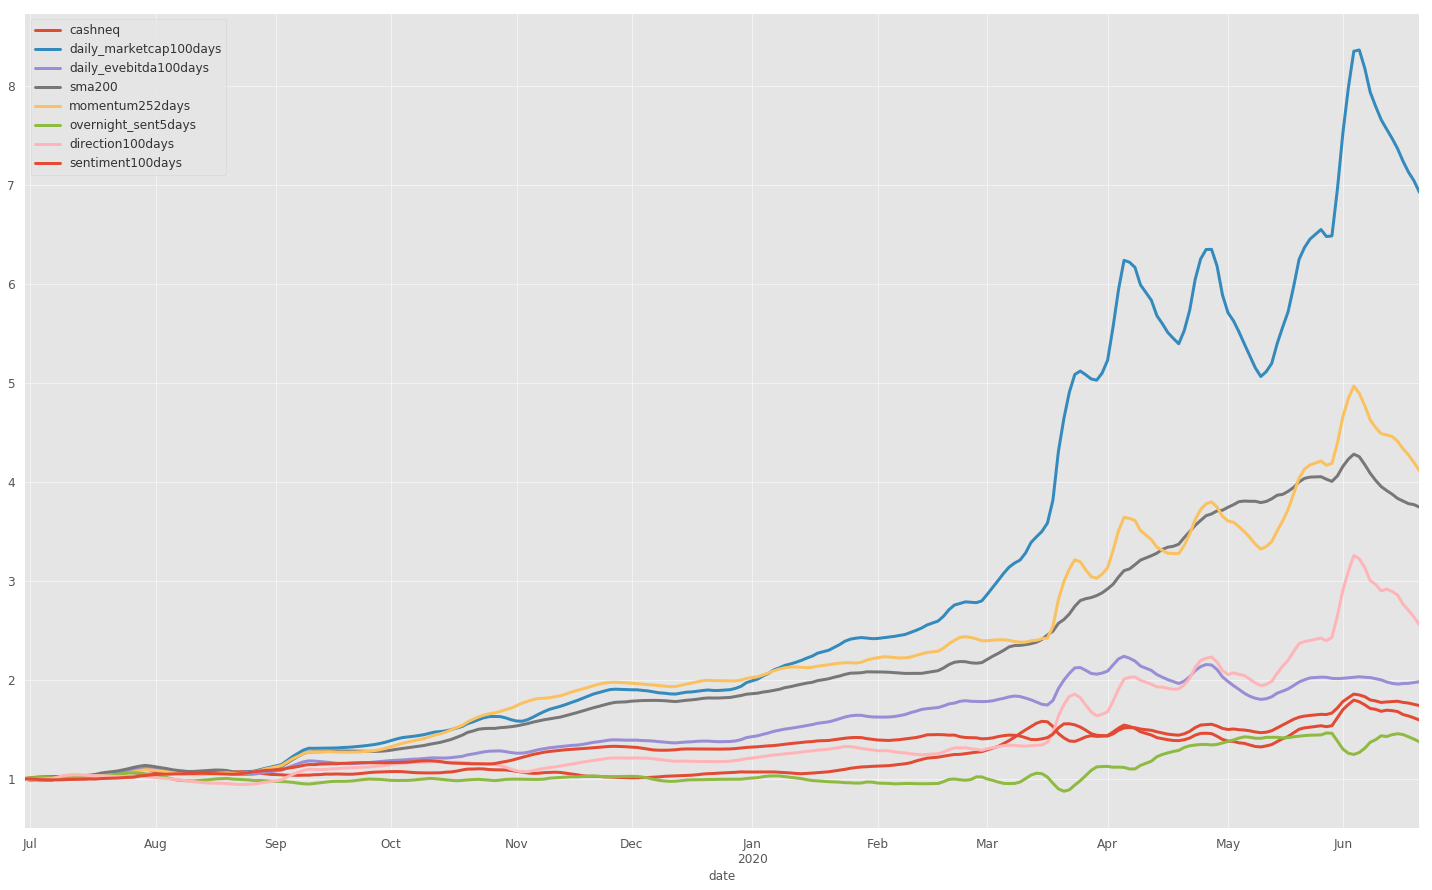

In [73]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 15)

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(lw=3);

### 5 - 2 - Quantile analysis

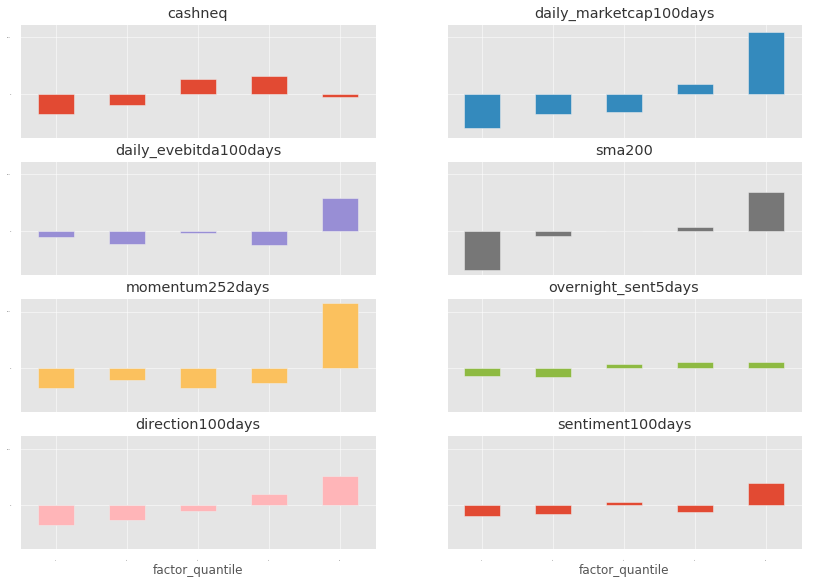

In [74]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(20,2),
    figsize=(14, 50),
    legend=False, fontsize=2);

### 5 - 3 - Factor Rank Autocorrelation

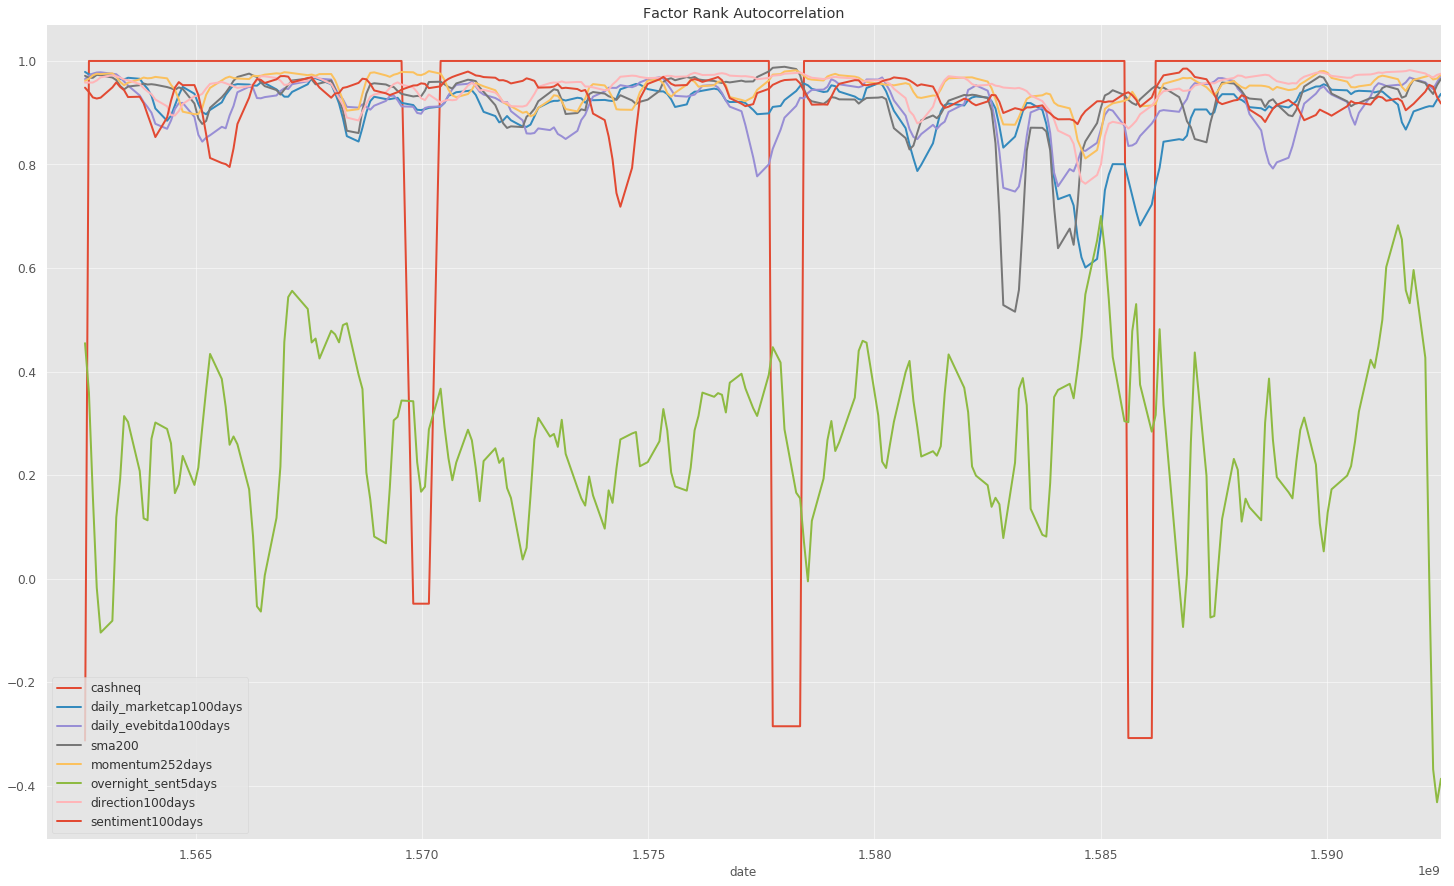

In [75]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data,period=rebalance_period)

ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

### 5 - 4 - Sharpe ratio

In [76]:
def sharpe_ratio(factor_returns, annualization_factor):

    df_sharpe = pd.Series(annualization_factor*factor_returns.mean()/factor_returns.std())
    
    return df_sharpe

In [77]:
daily_annualization_factor = np.sqrt(252)
df_sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [78]:
df_sharpe.sort_values(ascending=False)

sma200                    10.39
daily_marketcap100days     6.50
momentum252days            5.78
sentiment100days           4.34
daily_evebitda100days      4.21
direction100days           3.19
cashneq                    2.79
overnight_sent5days        1.52
dtype: float64

# 6 - Combined Alpha Factors

## 6 - 1 - Combining selceted factors

In [79]:

selected_factors = [
                         'sma200',
                         'daily_marketcap100days',
                         'direction100days',
                         'momentum252days',
                         'sentiment100days',
                         'cashneq'
                   ]

print('Selected Factors:\n{} '.format(',\n'.join(selected_factors)))

all_factors = all_factors[selected_factors]

Selected Factors:
sma200,
daily_marketcap100days,
direction100days,
momentum252days,
sentiment100days,
cashneq 


/home/k13104/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning:

All-NaN slice encountered



Time to train full ML pipline: 0.9652483463287354 secs
Accuracy on train set = 51.09%
Predictions: [-1. -1. -1. ... -1. -1. -1.]
Probabilities of class == 1: [49.99982944 49.99982944 49.99982944 ... 49.99982944 49.99982944
 49.99982944]
Accuracy on test set = 50.00%
Log-loss = 0.69315


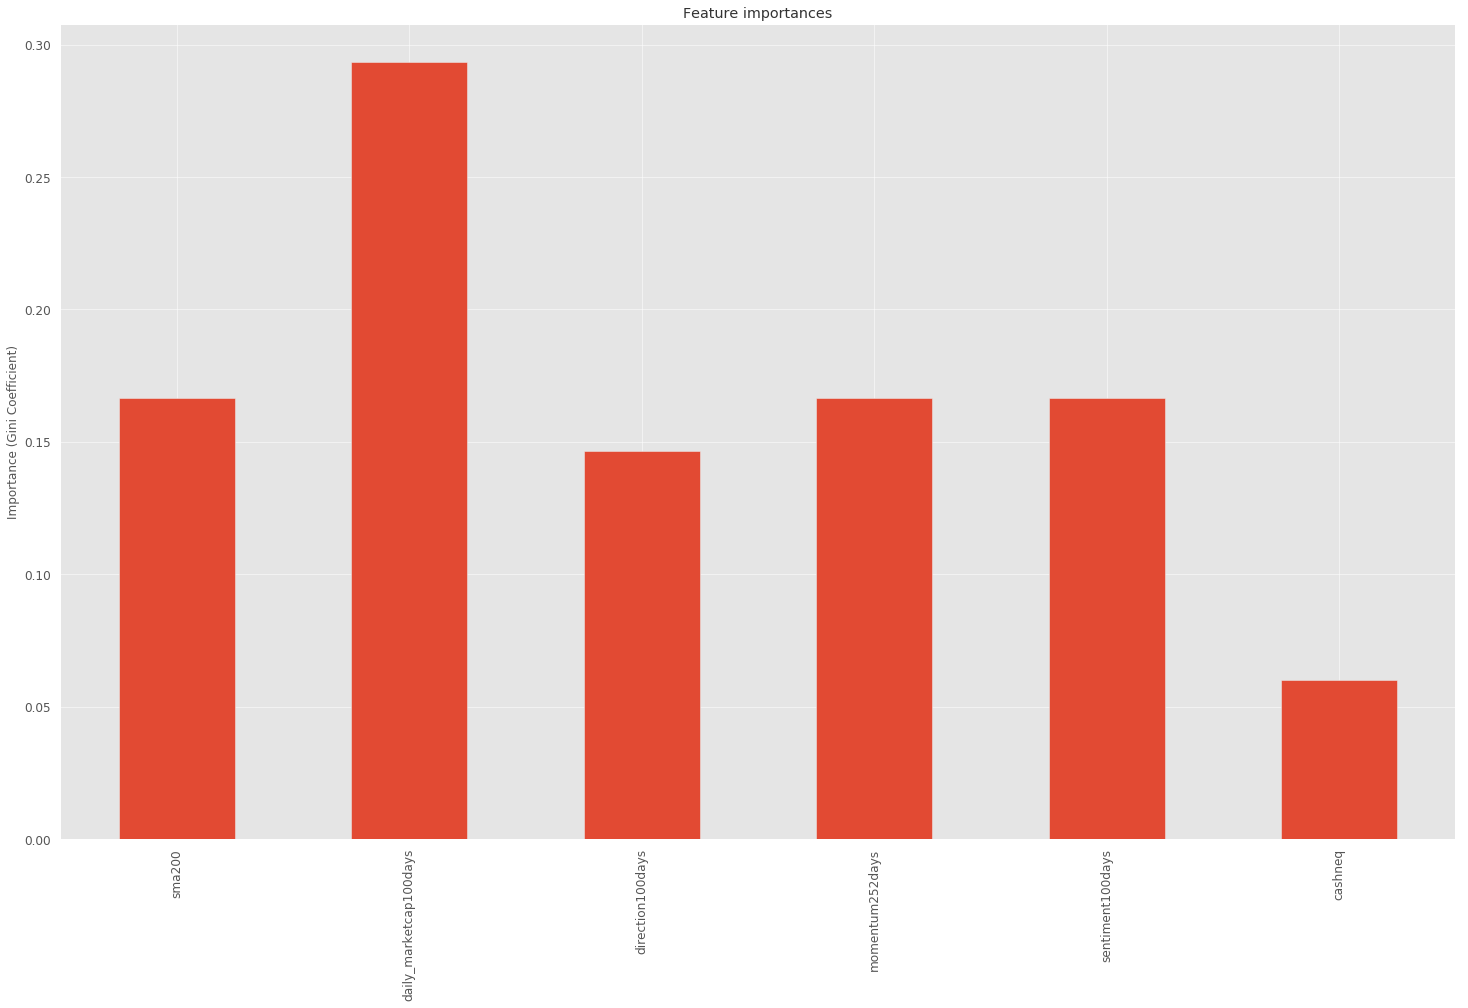

In [80]:
feature_importances = feature_weights.feature_importance(n_fwd_days = rebalance_period, 
                                                         close = close, 
                                                         all_factors = all_factors)

In [81]:
feature_importances

weights
factors                         
sma200                  0.166667
daily_marketcap100days  0.293333
direction100days        0.146667
momentum252days         0.166667
sentiment100days        0.166667
cashneq                 0.060000

In [82]:
all_factors_copy = all_factors.copy() 

In [83]:
for factor in selected_factors:
    all_factors_copy.loc[:,factor] = feature_importances.loc[factor][0] * all_factors.loc[:,factor]
all_factors_copy.loc[:,'alpha_vector'] = all_factors.sum(axis=1)
all_factors = all_factors_copy  

In [84]:
vec = pd.DataFrame(data=all_factors['alpha_vector'],columns = ['alpha_vector','sector'])
for date in vec.index.levels[0]:
    vec.loc[date,['sector']] = meta_ex_sc_cu.loc[vec.index.levels[1]]['sector'].values
sectors = vec['sector']


## 6 - 2 - Creating clean factor data

In [85]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = all_factors['alpha_vector'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = 5,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 6 - 3 - Creating tear sheets 

In [86]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period='{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       quantiles=[1,2,4,5],
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex

/usr/local/lib/python3.6/dist-packages/alphalens/performance.py:541: UserWarning:

'freq' not set, using business day calendar



/home/k13104/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning:


The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.



/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/home/k13104/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning:


The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.



/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



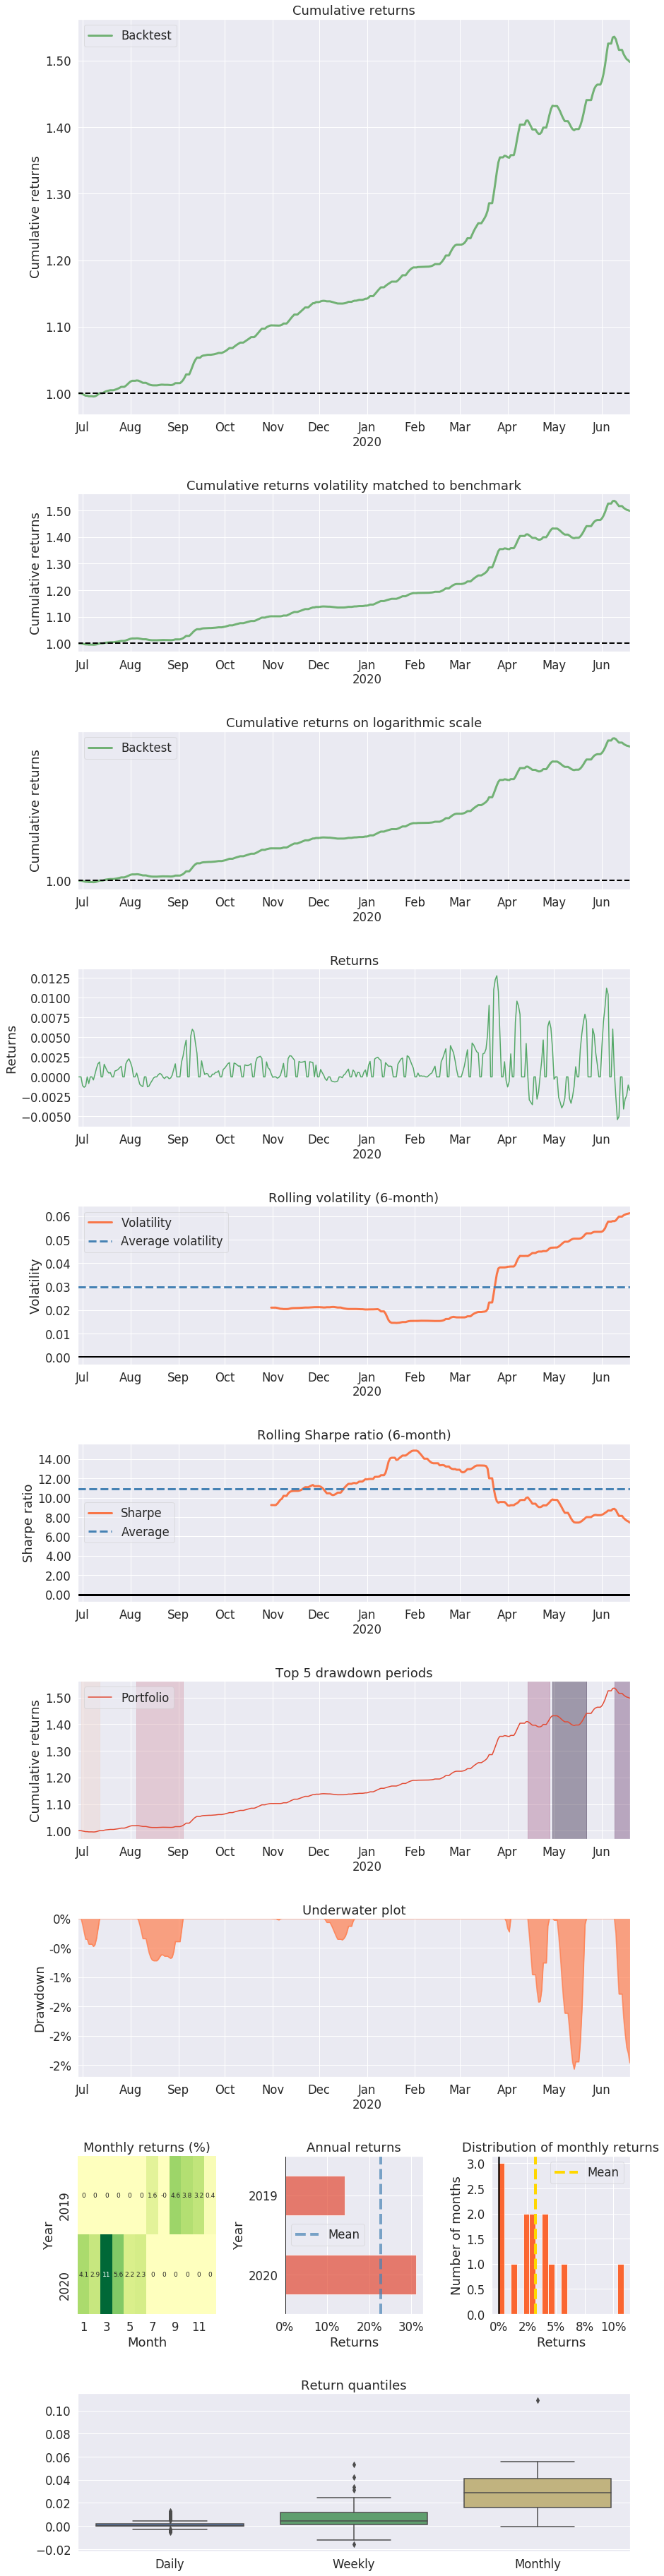

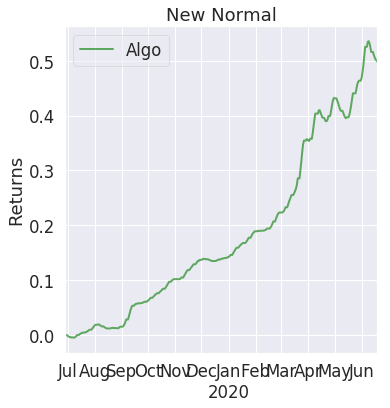

In [87]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min        max      mean       std  count  count %
factor_quantile                                                          
1               -11.752093  -1.646308 -4.279710  1.476187   8712     20.0
2                -4.892783  -0.120508 -1.759805  0.695808   8712     20.0
3                -2.110662   2.398702  0.035345  0.604491   8712     20.0
4                 0.222545   5.863258  1.896470  0.891482   8712     20.0
5                 2.054080  14.455735  4.736730  1.830815   8712     20.0

Returns Analysis


3D       5D      10D
Ann. alpha                                       0.476    0.472    0.423
beta                                             0.207    0.166    0.050
Mean Period Wise Return Top Quantile (bps)      71.927   68.720   58.424
Mean Period Wise Return Bottom Quantile (bps)  -51.972  -51.008  -45.823
Mean Period Wise Spread (bps)                  123.898  119.154  103.588

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



<Figure size 1800x1080 with 0 Axes>

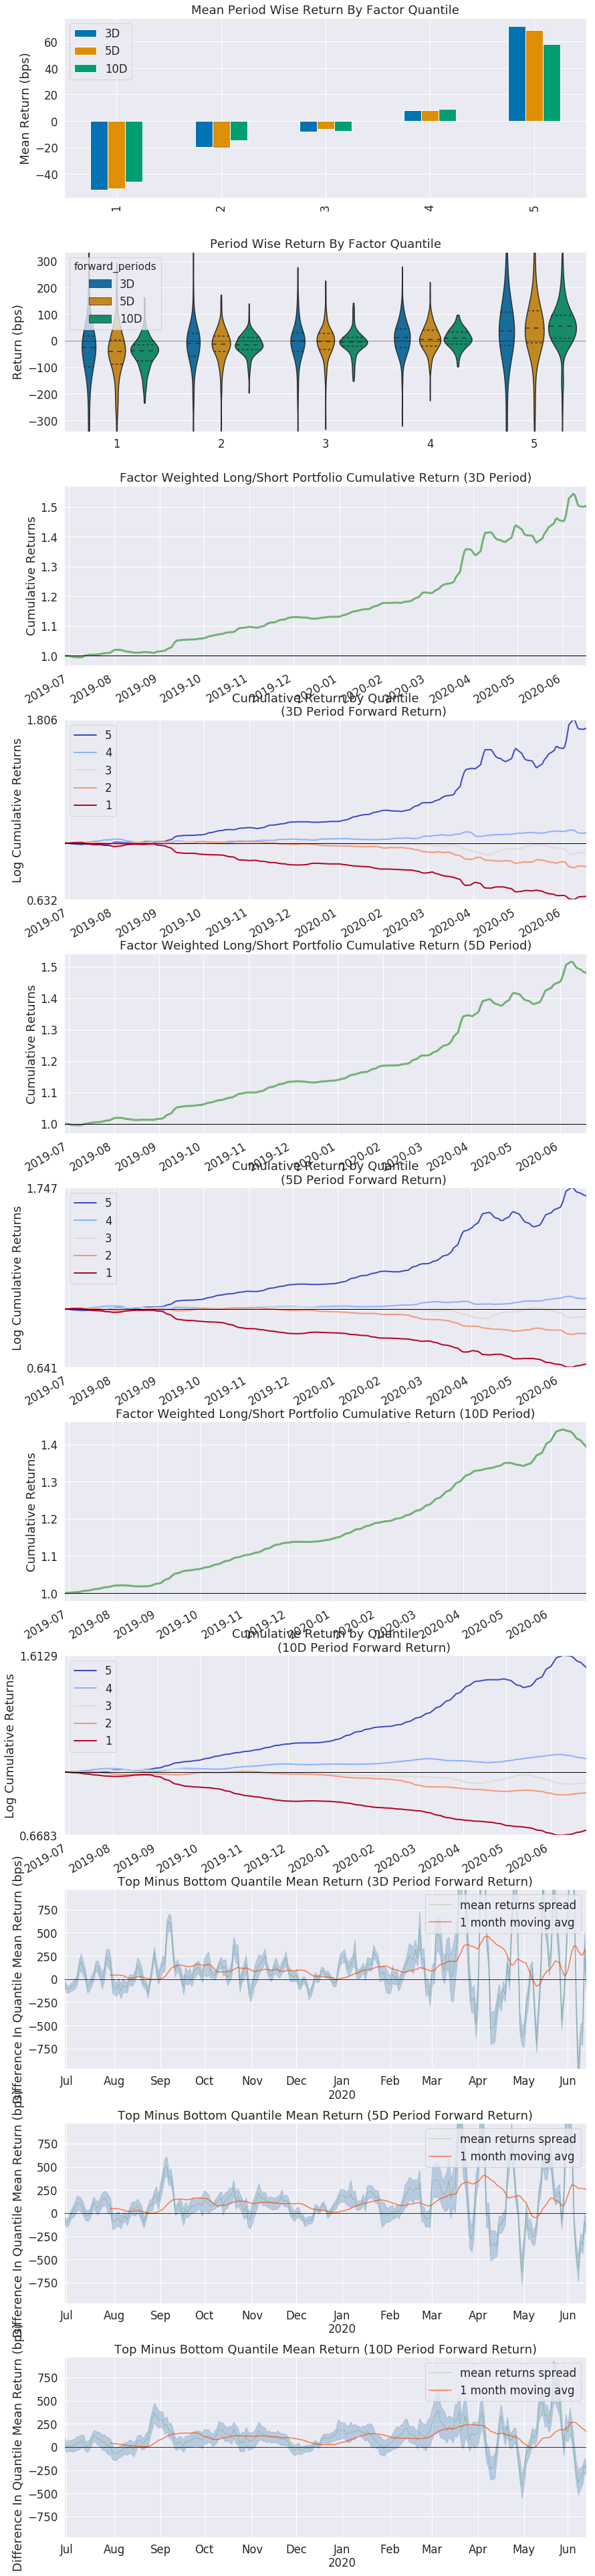

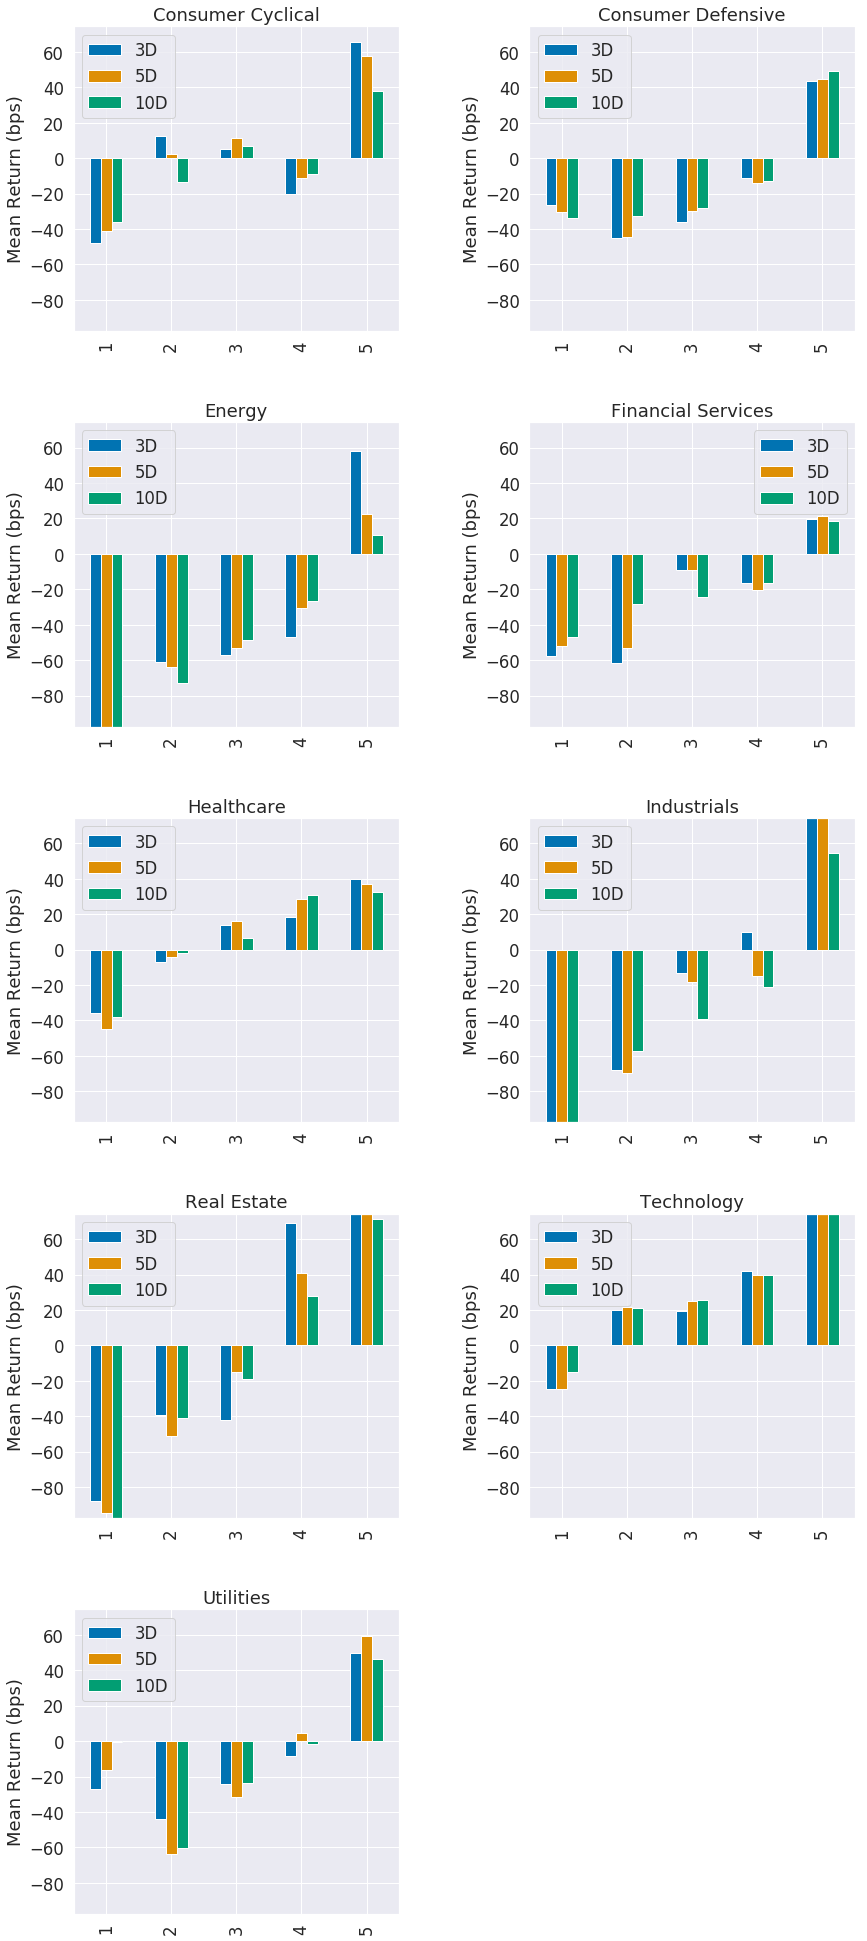

Information Analysis


3D     5D     10D
IC Mean           0.074  0.099   0.147
IC Std.           0.196  0.198   0.183
Risk-Adjusted IC  0.375  0.497   0.803
t-stat(IC)        5.837  7.730  12.499
p-value(IC)       0.000  0.000   0.000
IC Skew          -0.105 -0.125  -0.748
IC Kurtosis       0.075 -0.208   0.615

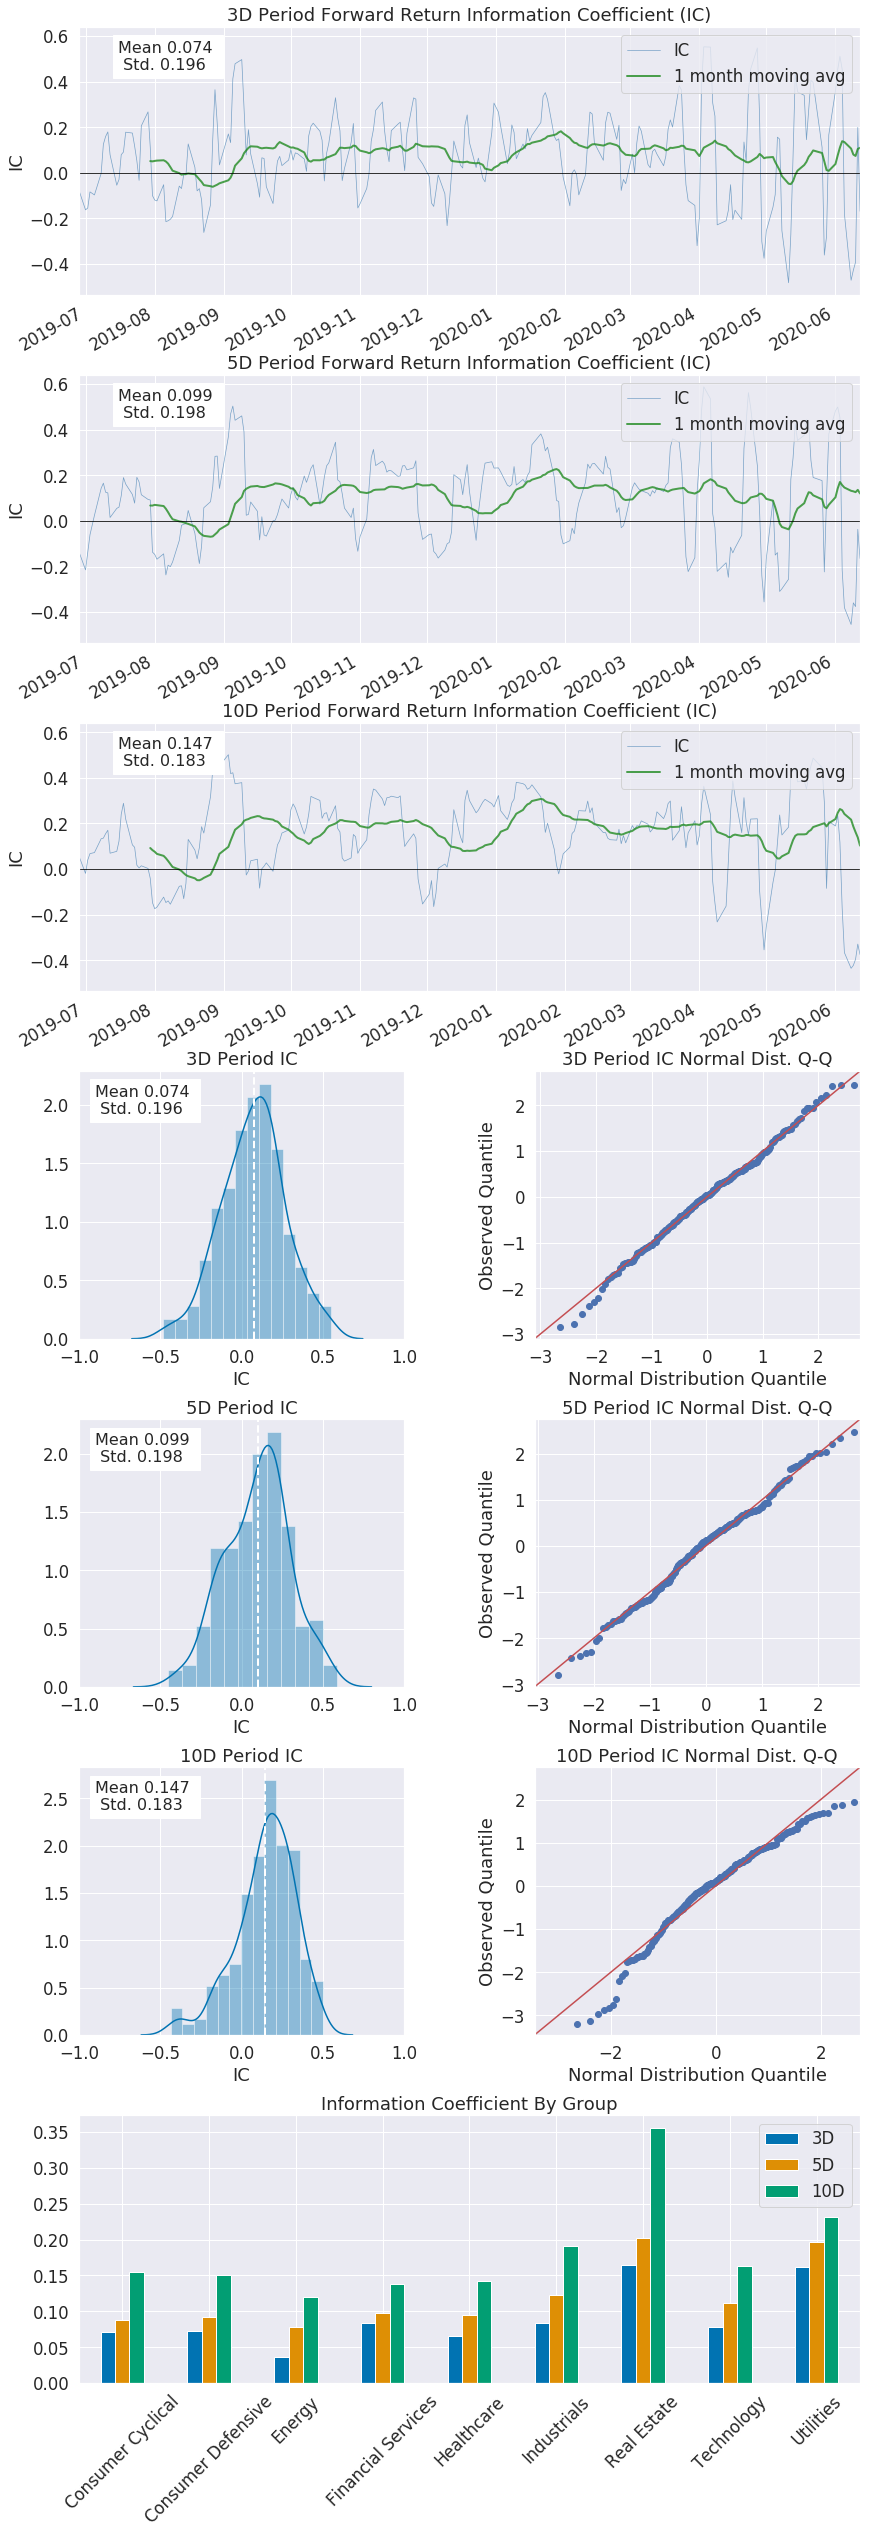

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.317  0.133  0.202
Quantile 2 Mean Turnover   0.557  0.287  0.403
Quantile 3 Mean Turnover   0.586  0.314  0.434
Quantile 4 Mean Turnover   0.550  0.288  0.406
Quantile 5 Mean Turnover   0.302  0.132  0.198

3D     5D    10D
Mean Factor Rank Autocorrelation  0.964  0.925  0.832

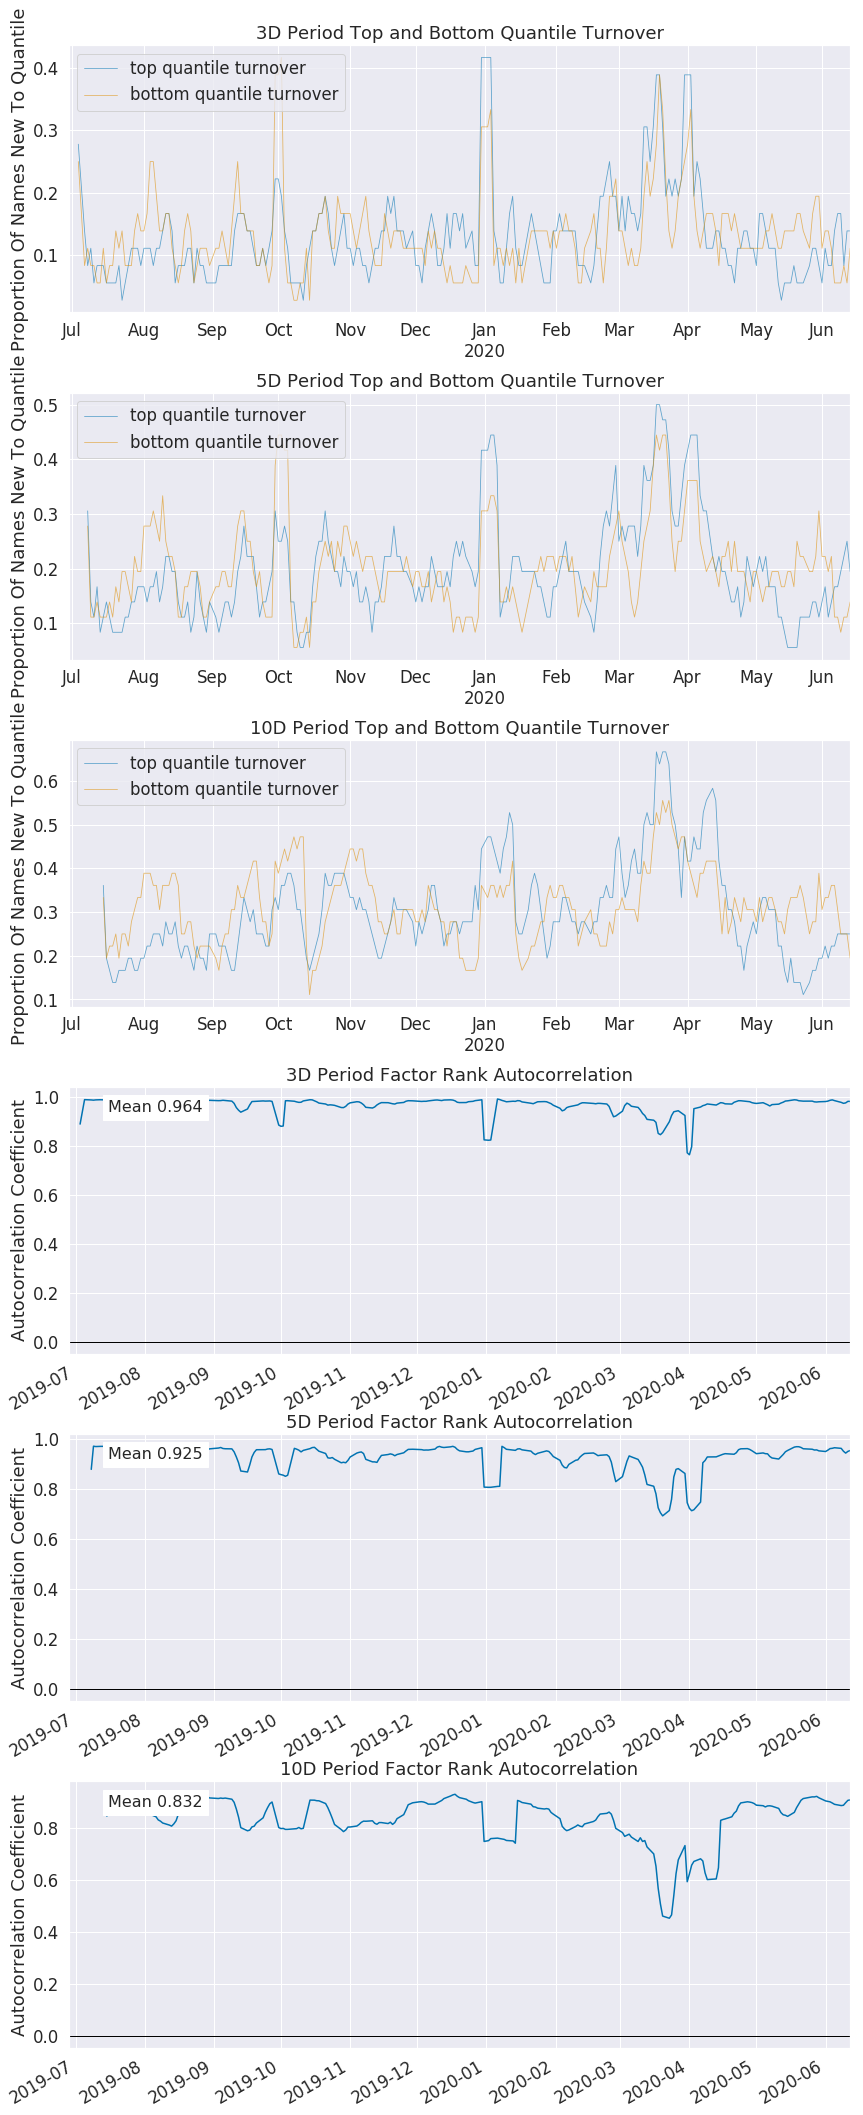

In [88]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



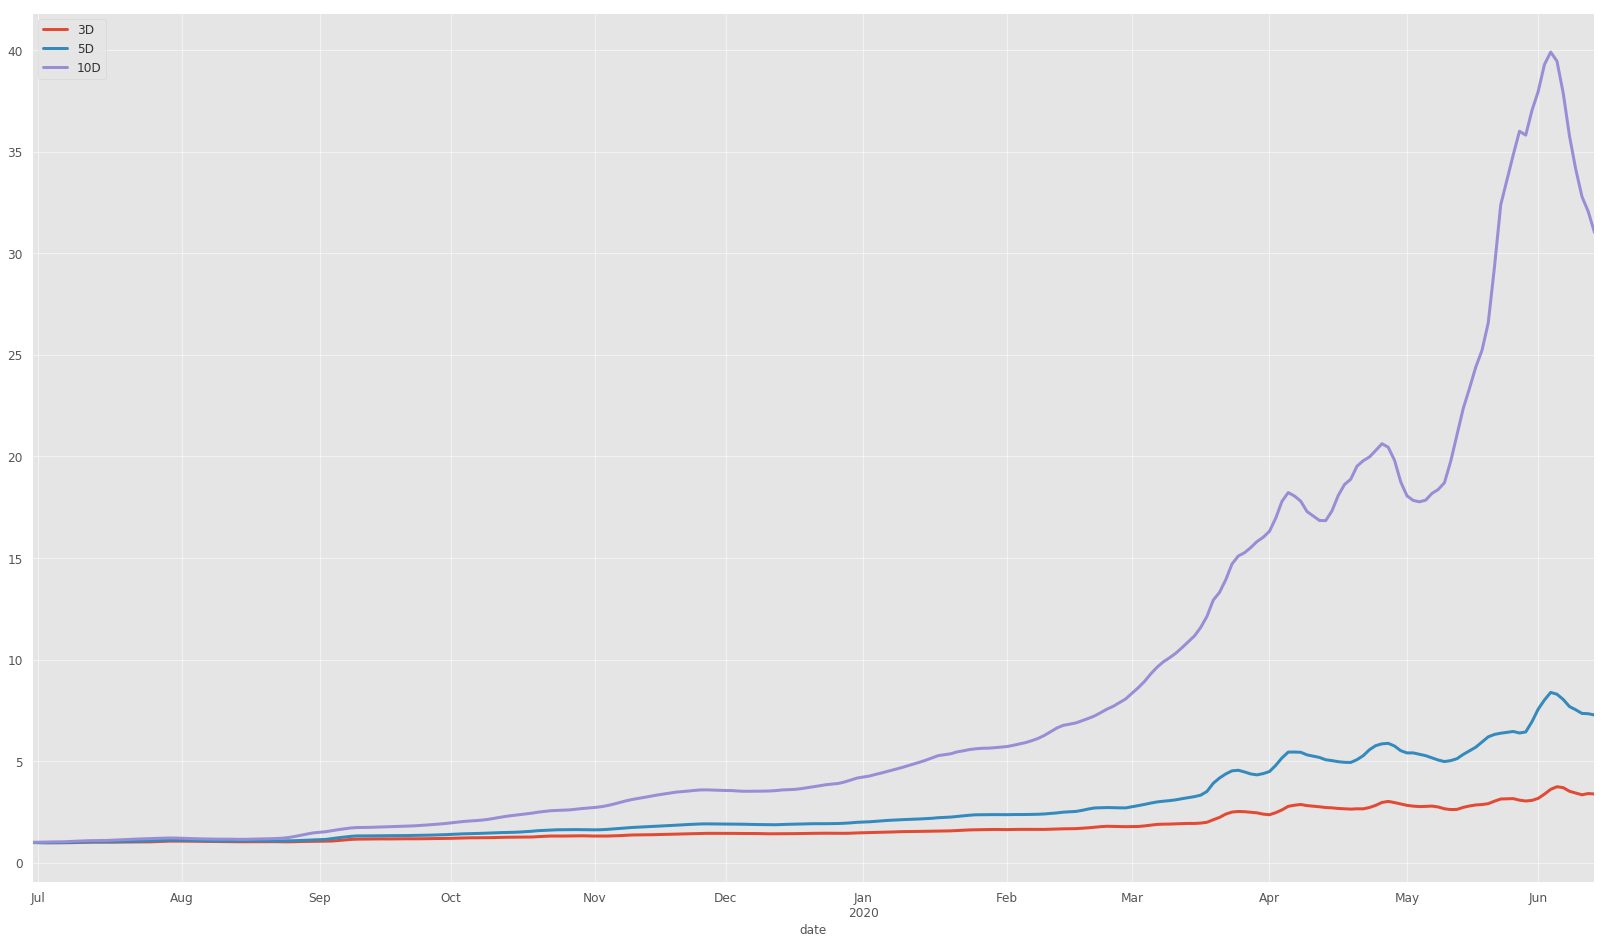

In [89]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

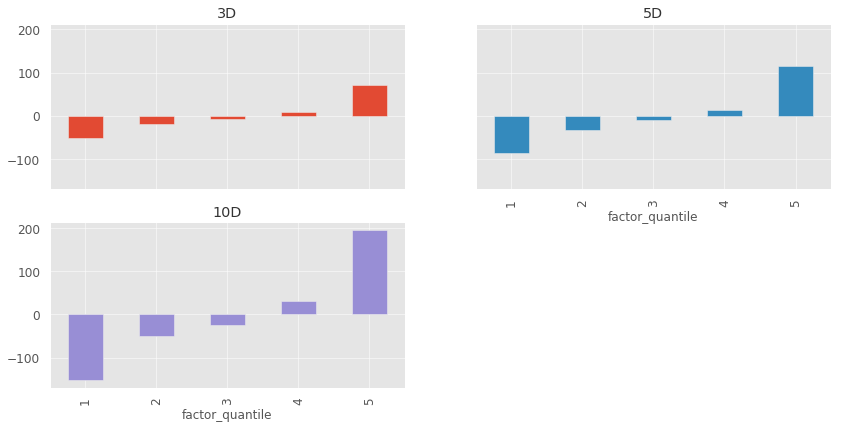

In [90]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

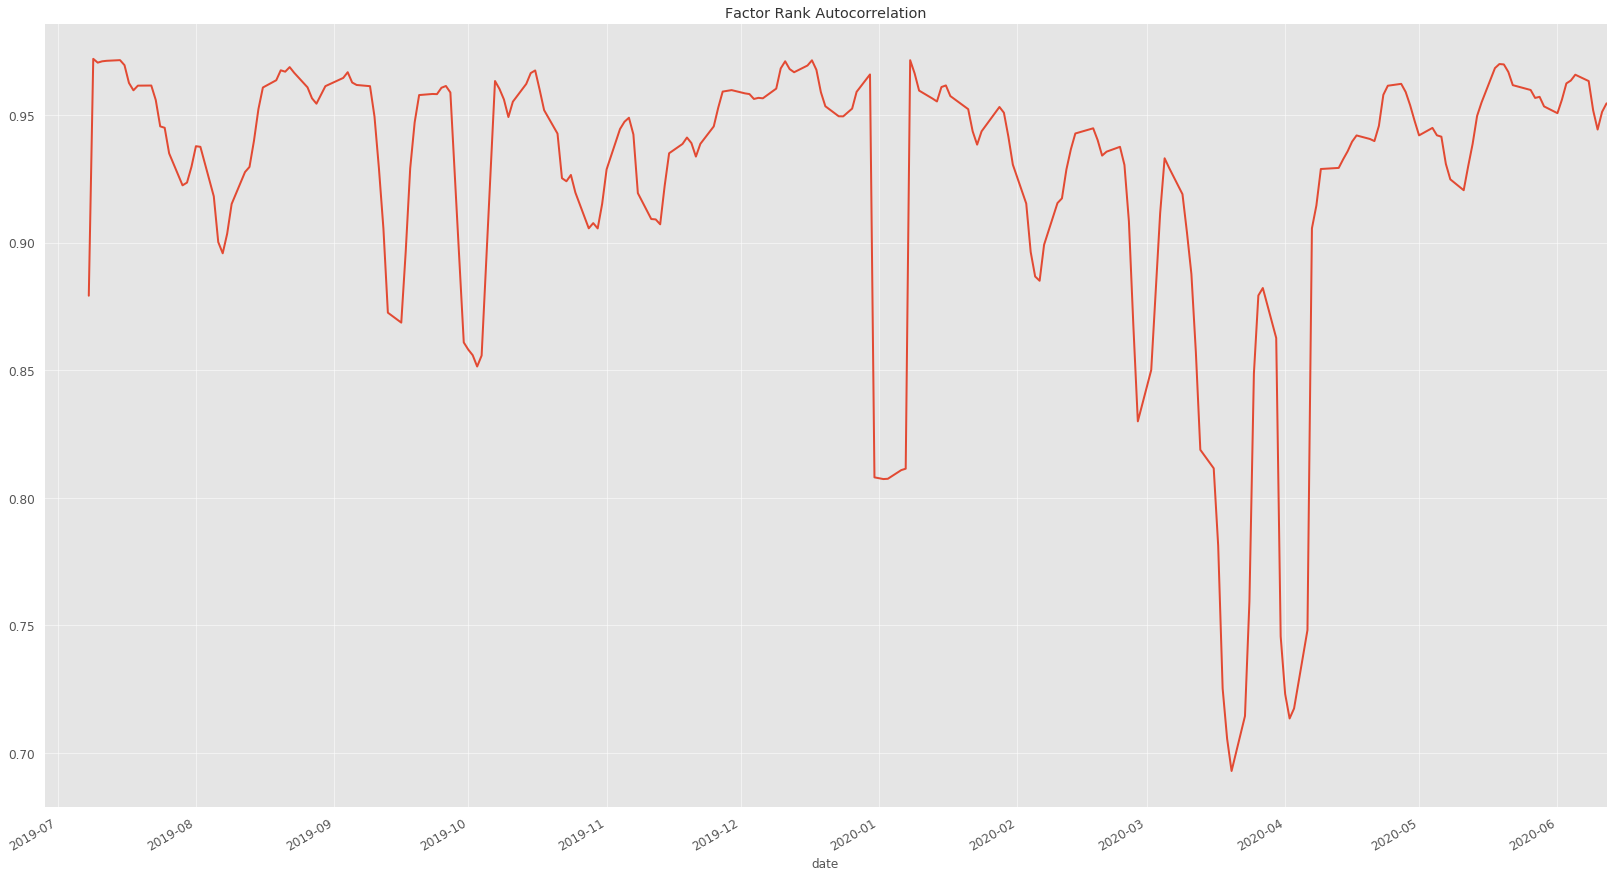

In [91]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [92]:
ls_FRA.mean()

0.9246225367949702

In [93]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D      5.23
5D      7.03
10D    11.35
dtype: float64

# 7 -  Risk Analysis for Equal Weights

In [94]:
assets = all_factors.index.levels[1]

In [95]:
all_weights = pd.DataFrame(np.repeat(1/len(assets), len(assets)), assets)

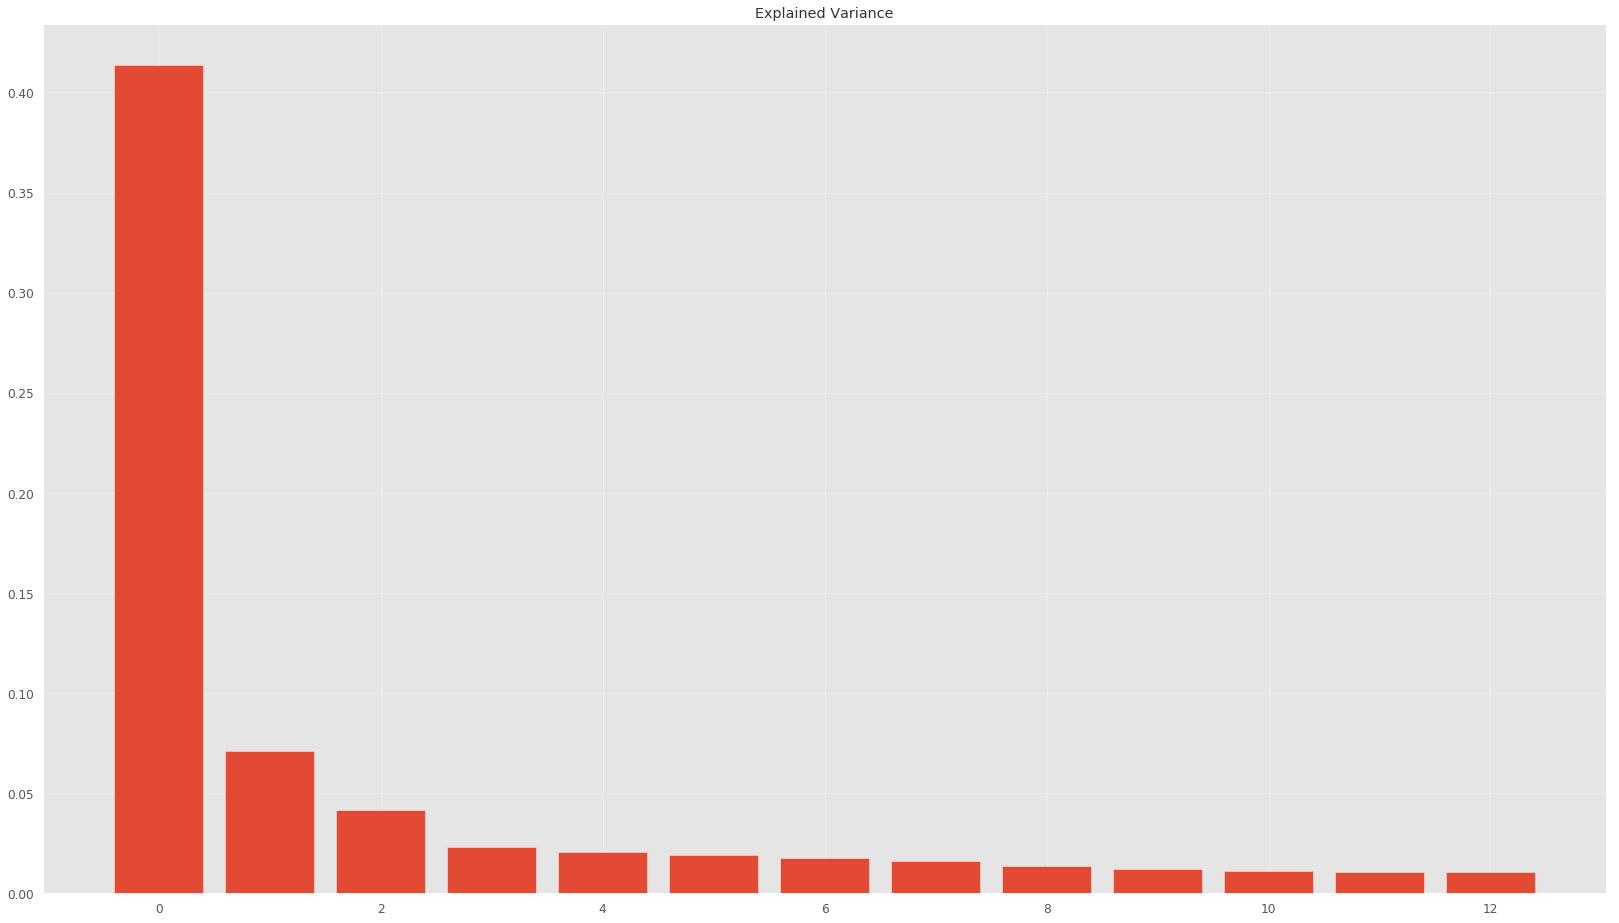

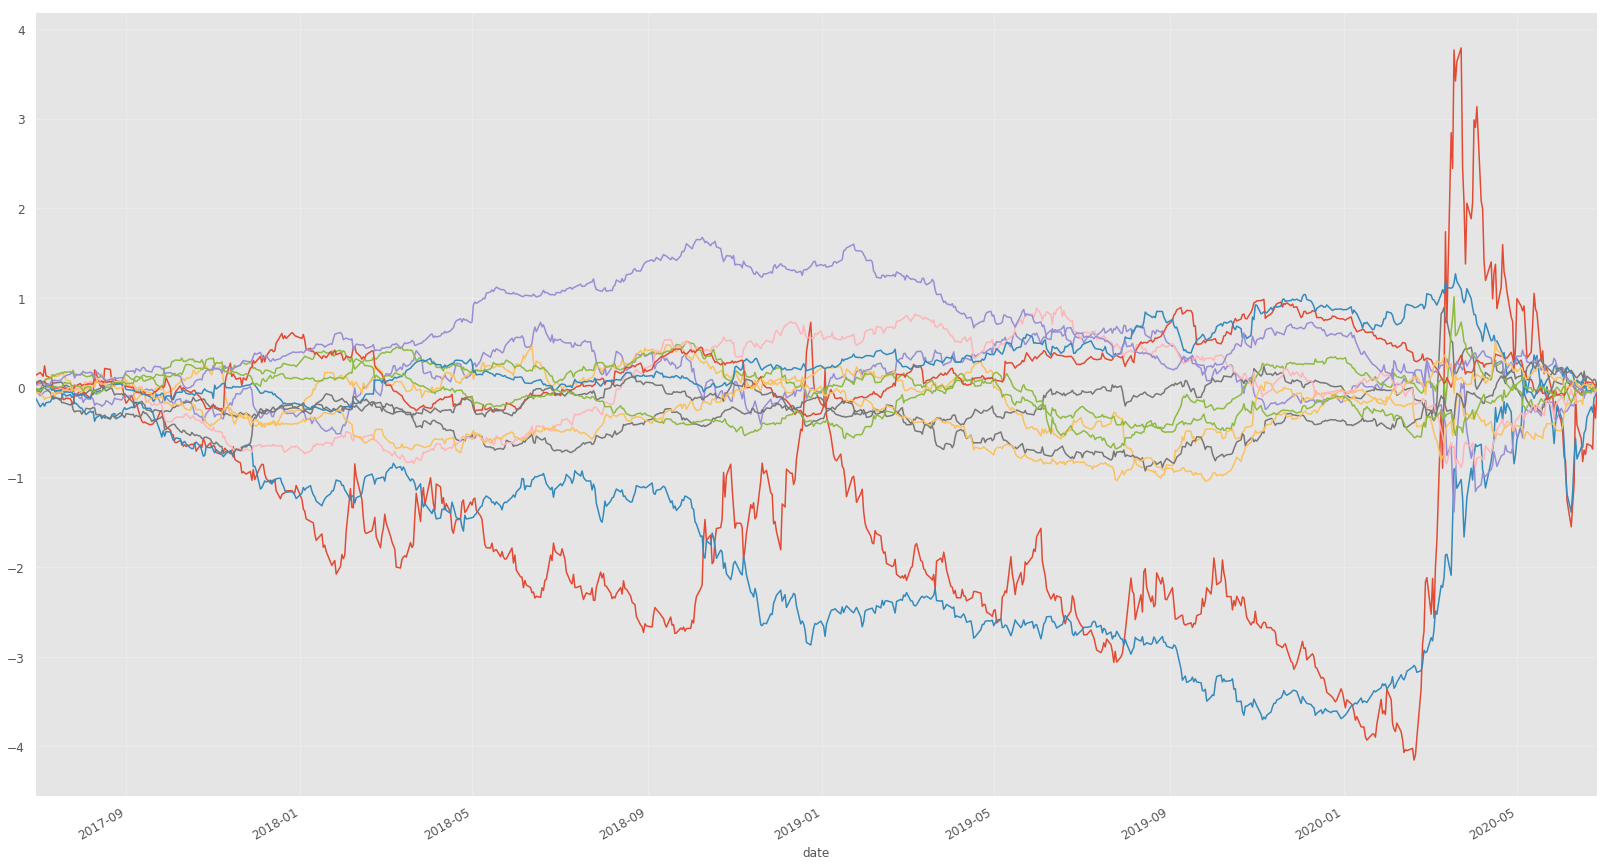

In [96]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[assets],num_factor_exposures=13,weights=all_weights)

In [97]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 24.8 %


# 9 - Integrating optimzer to factor data

In [98]:
optimal = pd.DataFrame(index = all_factors.index.levels[0], columns = all_factors.index.levels[1])
for date in all_factors.index.levels[0]:
    
    x = all_factors[['alpha_vector']].loc[date.date(),:]
    optimal.loc[date,:] = risk_model\
    .OptimalHoldingsRegualization(lambda_reg = lambda_reg,
                                  risk_cap = risk_cap).find(
                                                            x, 
                                                            Risk_Model['factor_betas'], 
                                                            Risk_Model['factor_cov_matrix'], 
                                                            Risk_Model['idiosyncratic_var_vector']).values.flatten()
optimal = optimal.astype(np.float)

In [99]:
optimal_stacked = optimal.stack().to_frame('optimal_weights')

## 9 - 2 - Creating clean factor data

In [100]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor = optimal_stacked['optimal_weights'], 
                                                          prices = pricing, 
                                                          periods = combined_periods,
                                                          quantiles = 5,
                                                          groupby=sectors,
                                                          binning_by_group=False,
                                                          filter_zscore=20,
                                                          max_loss=0.15)

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!


## 9 - 3 - Creating tear sheets 

In [101]:
pf_returns, pf_positions, pf_benchmark = \
al.performance.create_pyfolio_input(factor_data,
                                       period= '{}D'.format(rebalance_period),
                                       capital=10000,
                                       long_short=True,
                                       group_neutral=False,
                                       equal_weight=False,
                                       groups=sectors,
                                       benchmark_period='{}D'.format(rebalance_period))

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex

/usr/local/lib/python3.6/dist-packages/alphalens/performance.py:541: UserWarning:

'freq' not set, using business day calendar



/home/k13104/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning:


The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.



/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/home/k13104/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning:


The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.



/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



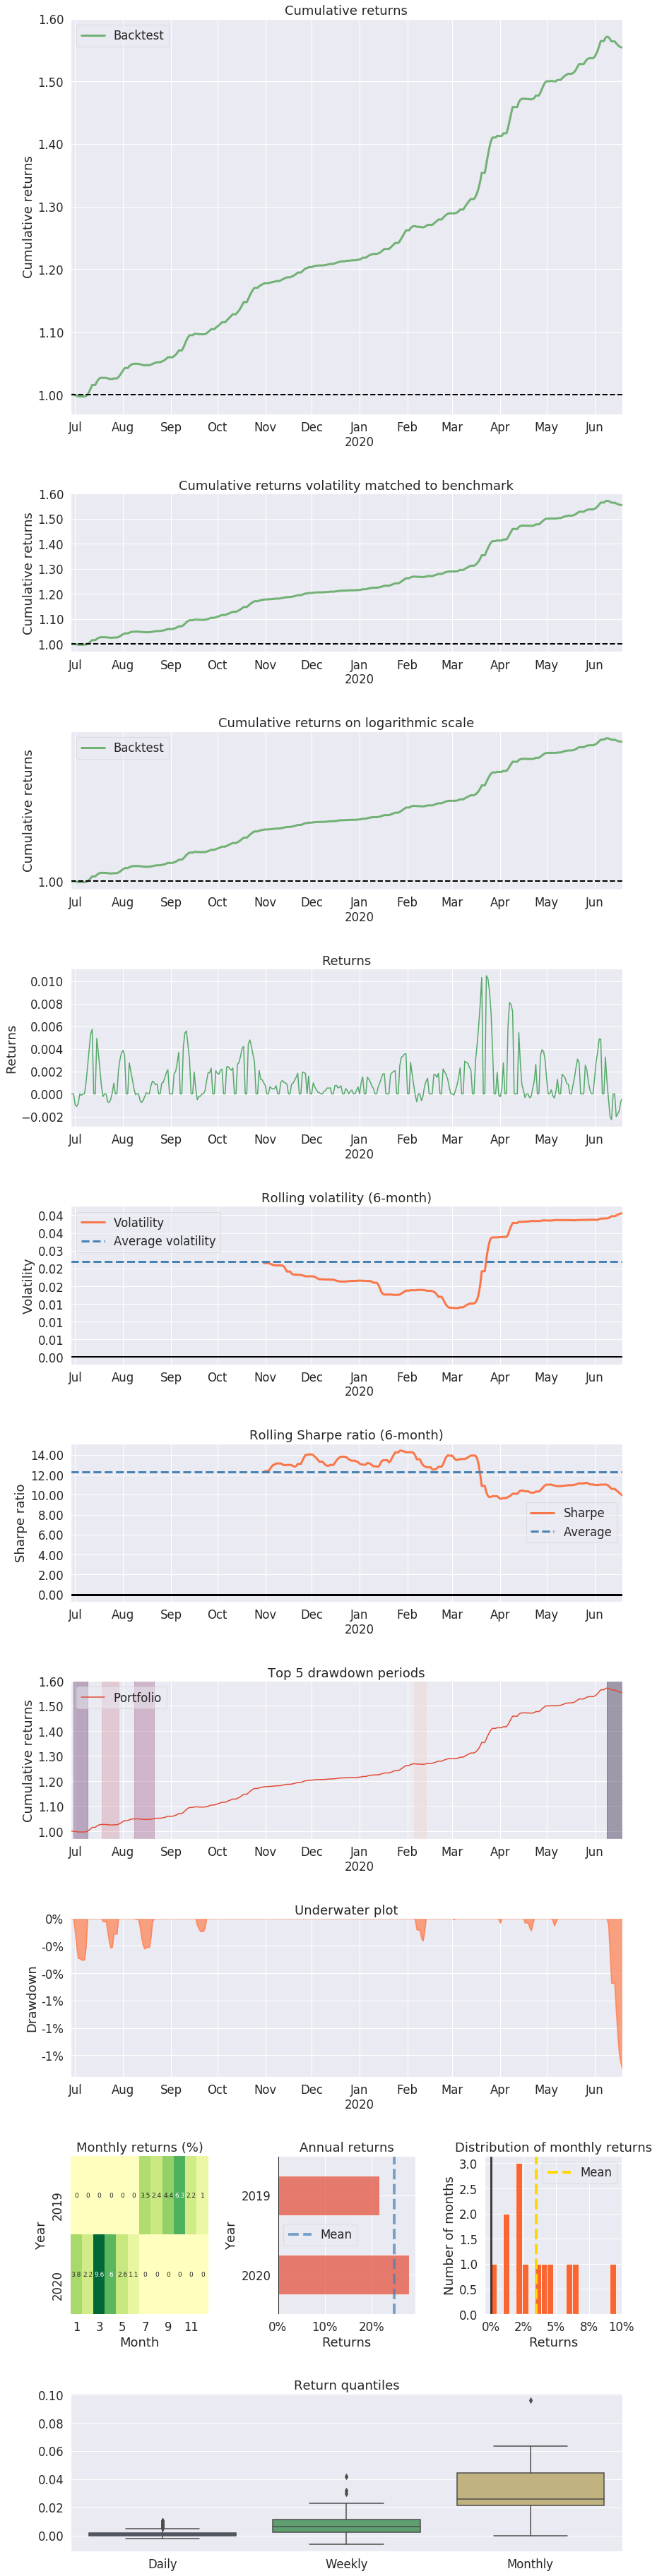

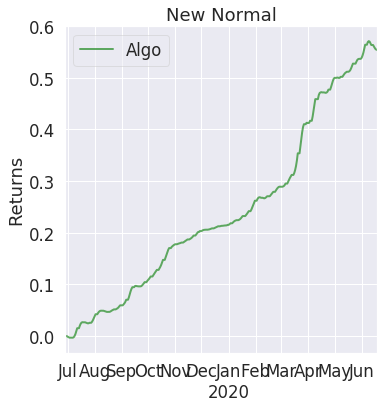

In [102]:
pf.create_full_tear_sheet(pf_returns)

Quantiles Statistics


min           max          mean           std  \
factor_quantile                                                           
1               -2.096865e-01 -1.809038e-11 -1.388889e-02  2.832581e-02   
2               -1.871816e-08  8.806202e-12 -3.722400e-10  6.673188e-10   
3               -1.249537e-09  7.662015e-10  9.760285e-12  1.378365e-10   
4                4.437296e-12  5.061267e-09  3.970285e-10  4.258319e-10   
5                2.499882e-11  2.092520e-01  1.388889e-02  2.552429e-02   

                 count  count %  
factor_quantile                  
1                 8712     20.0  
2                 8712     20.0  
3                 8712     20.0  
4                 8712     20.0  
5                 8712     20.0

Returns Analysis


3D      5D     10D
Ann. alpha                                      0.567   0.565   0.512
beta                                            0.103   0.088   0.026
Mean Period Wise Return Top Quantile (bps)     51.567  52.351  46.973
Mean Period Wise Return Bottom Quantile (bps) -34.229 -33.757 -34.185
Mean Period Wise Spread (bps)                  85.796  85.980  81.009

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



<Figure size 2016x1152 with 0 Axes>

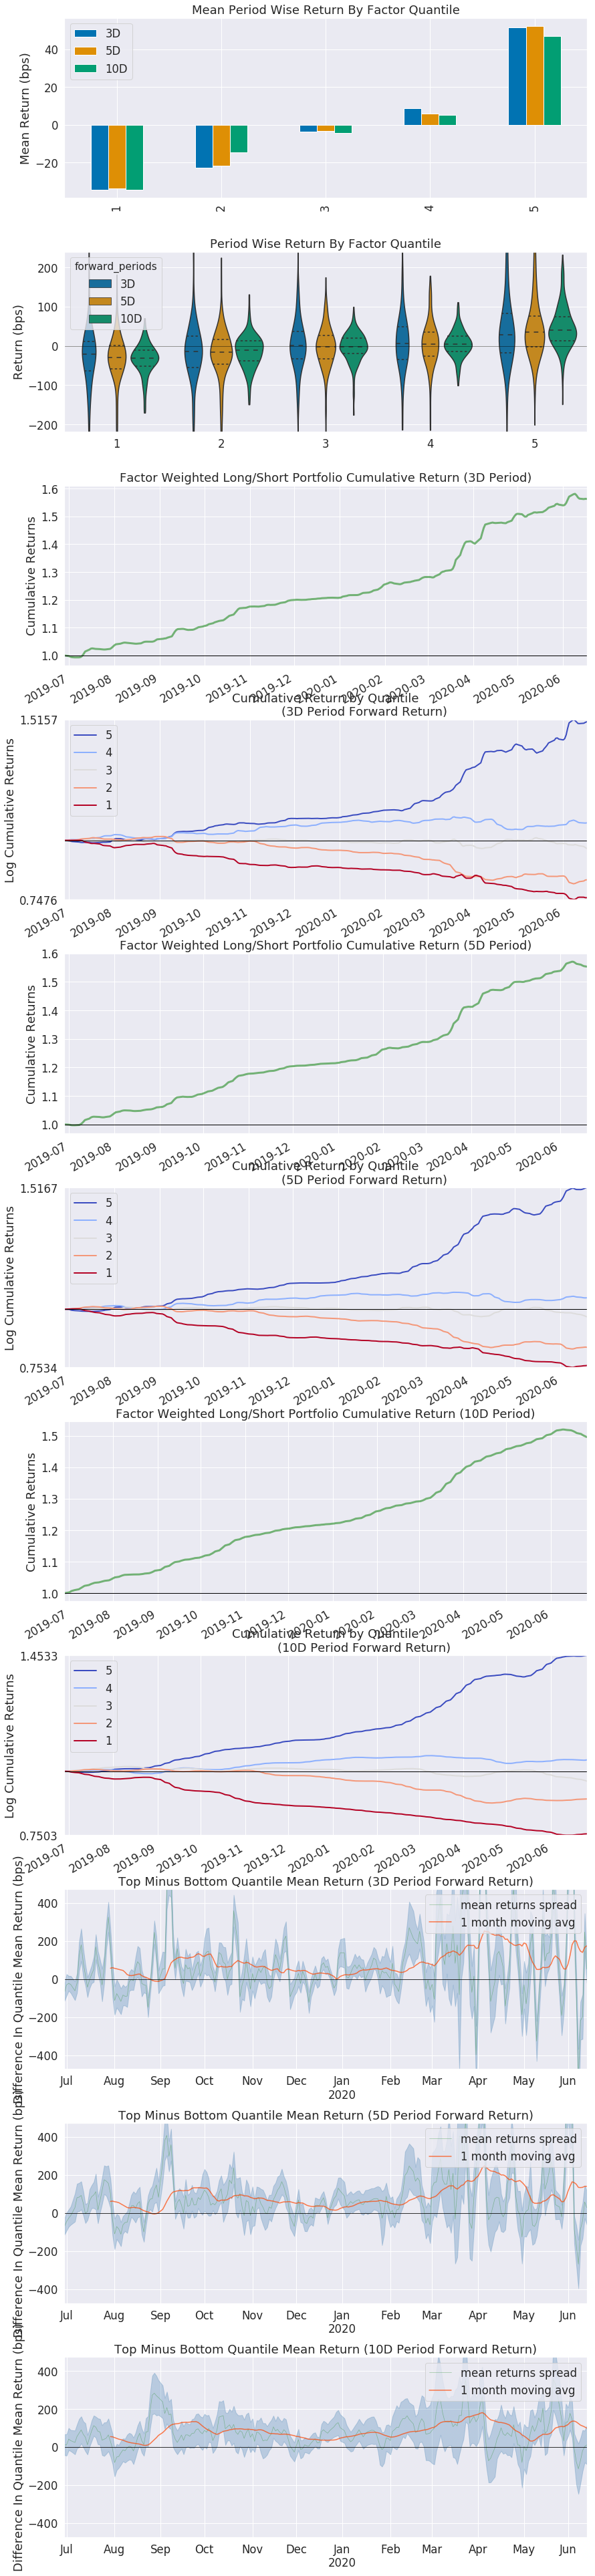

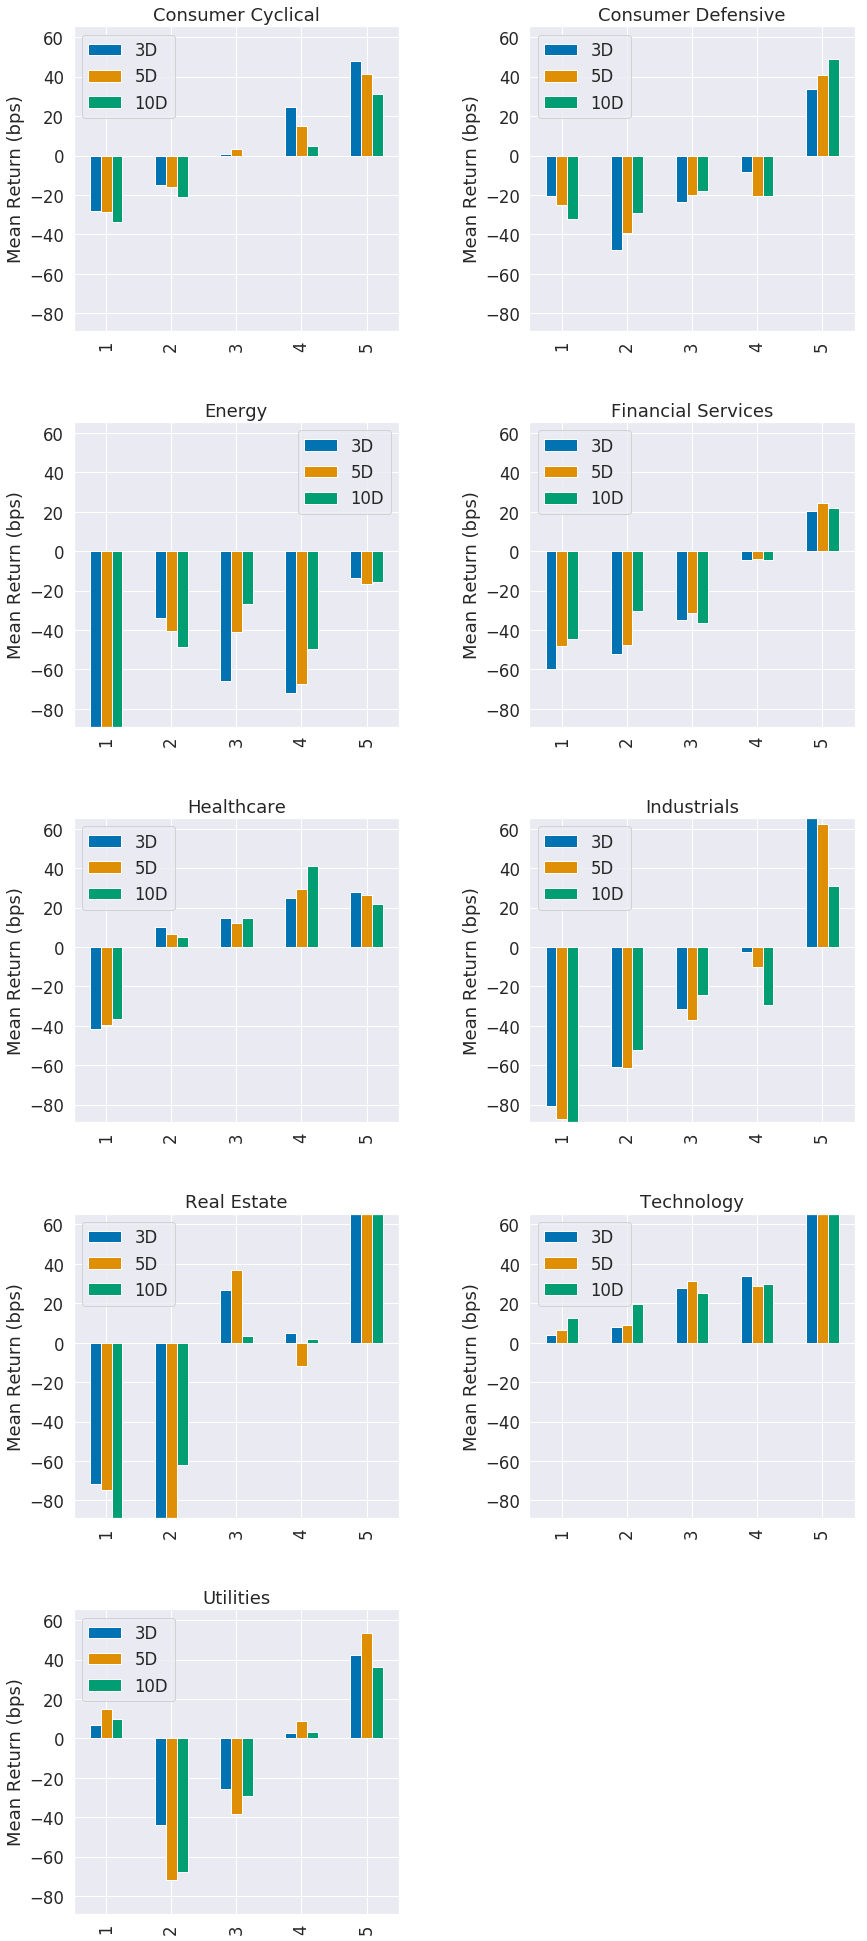

Information Analysis


3D     5D     10D
IC Mean           0.061  0.081   0.122
IC Std.           0.129  0.129   0.118
Risk-Adjusted IC  0.470  0.624   1.031
t-stat(IC)        7.309  9.709  16.044
p-value(IC)       0.000  0.000   0.000
IC Skew           0.331  0.223  -0.147
IC Kurtosis       0.415  0.013   0.316

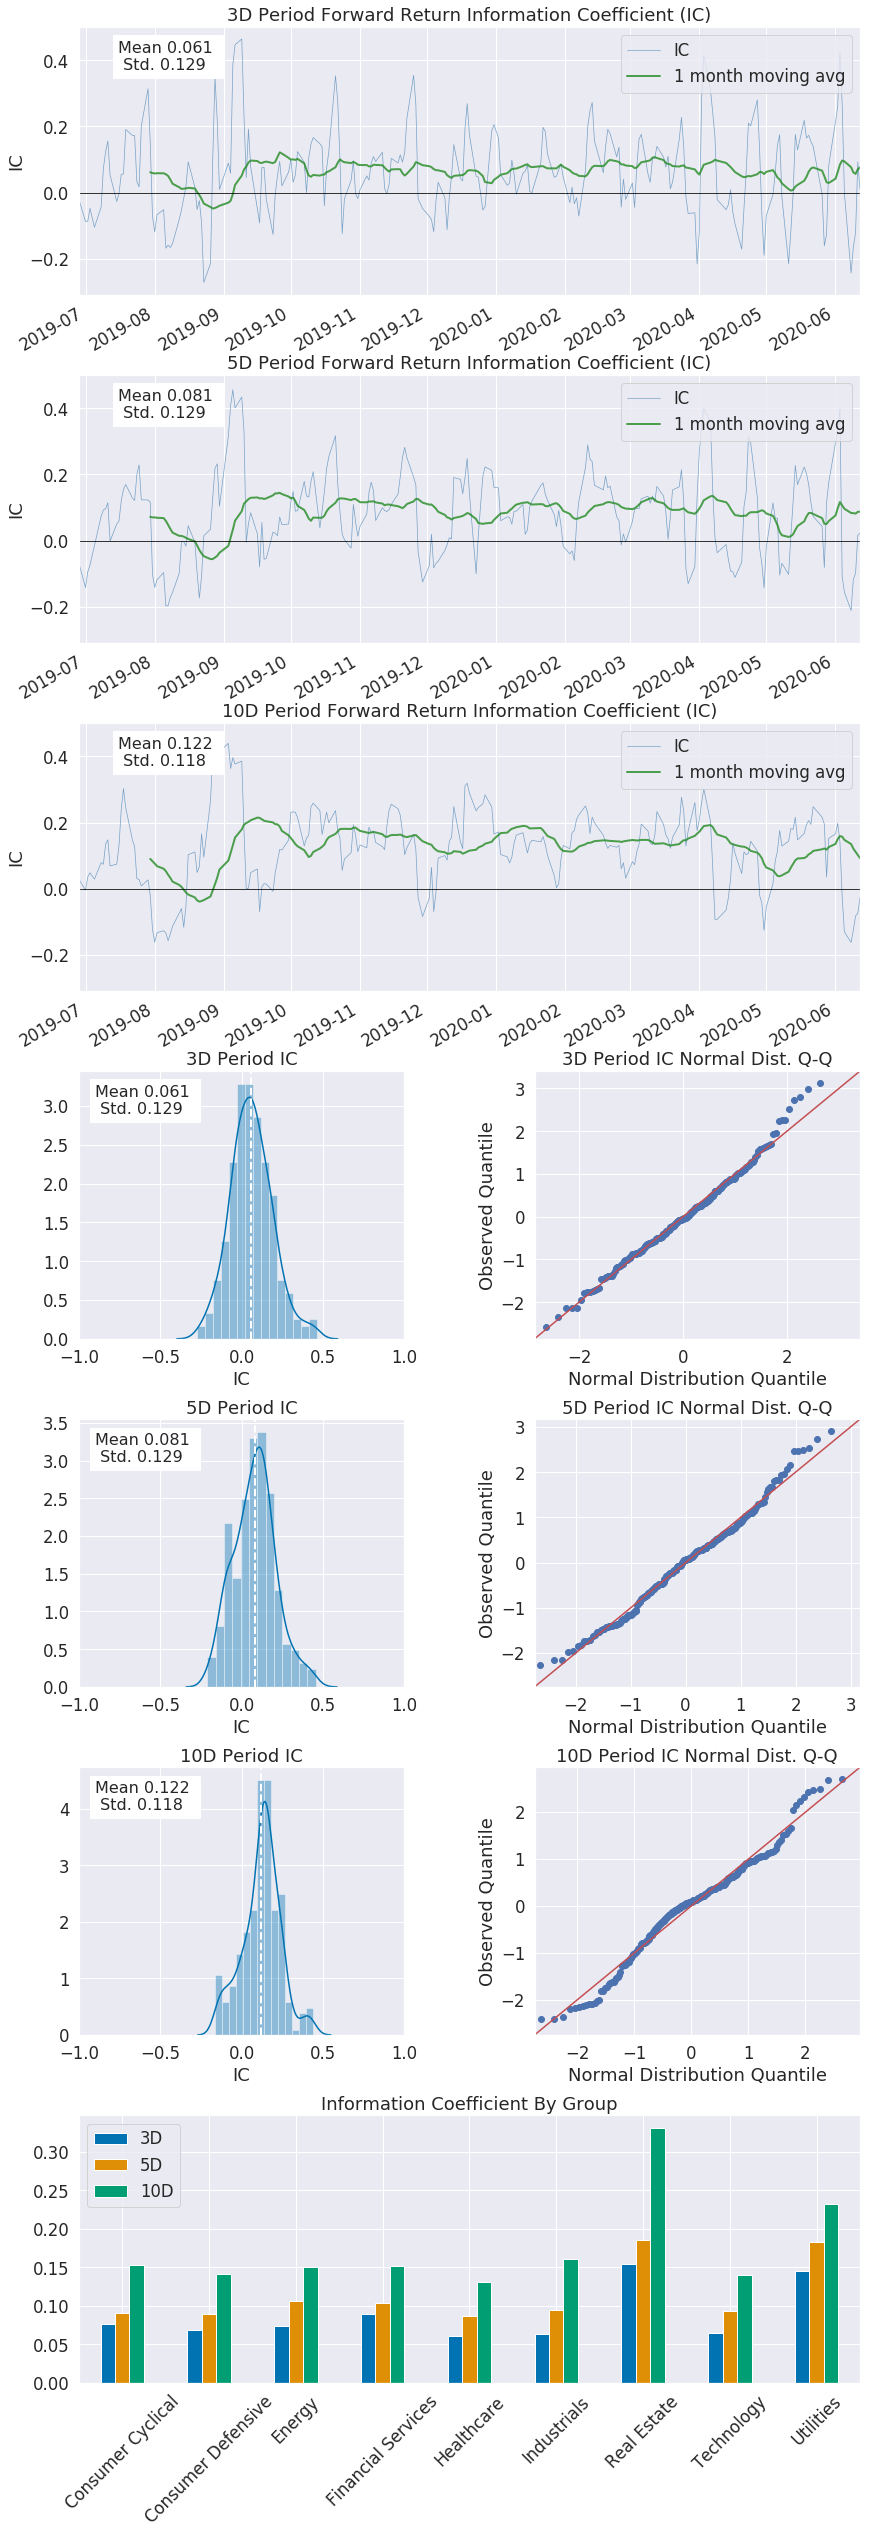

Turnover Analysis


10D     3D     5D
Quantile 1 Mean Turnover   0.327  0.144  0.214
Quantile 2 Mean Turnover   0.563  0.307  0.428
Quantile 3 Mean Turnover   0.611  0.341  0.465
Quantile 4 Mean Turnover   0.569  0.306  0.419
Quantile 5 Mean Turnover   0.310  0.133  0.196

3D     5D   10D
Mean Factor Rank Autocorrelation  0.958  0.913  0.81

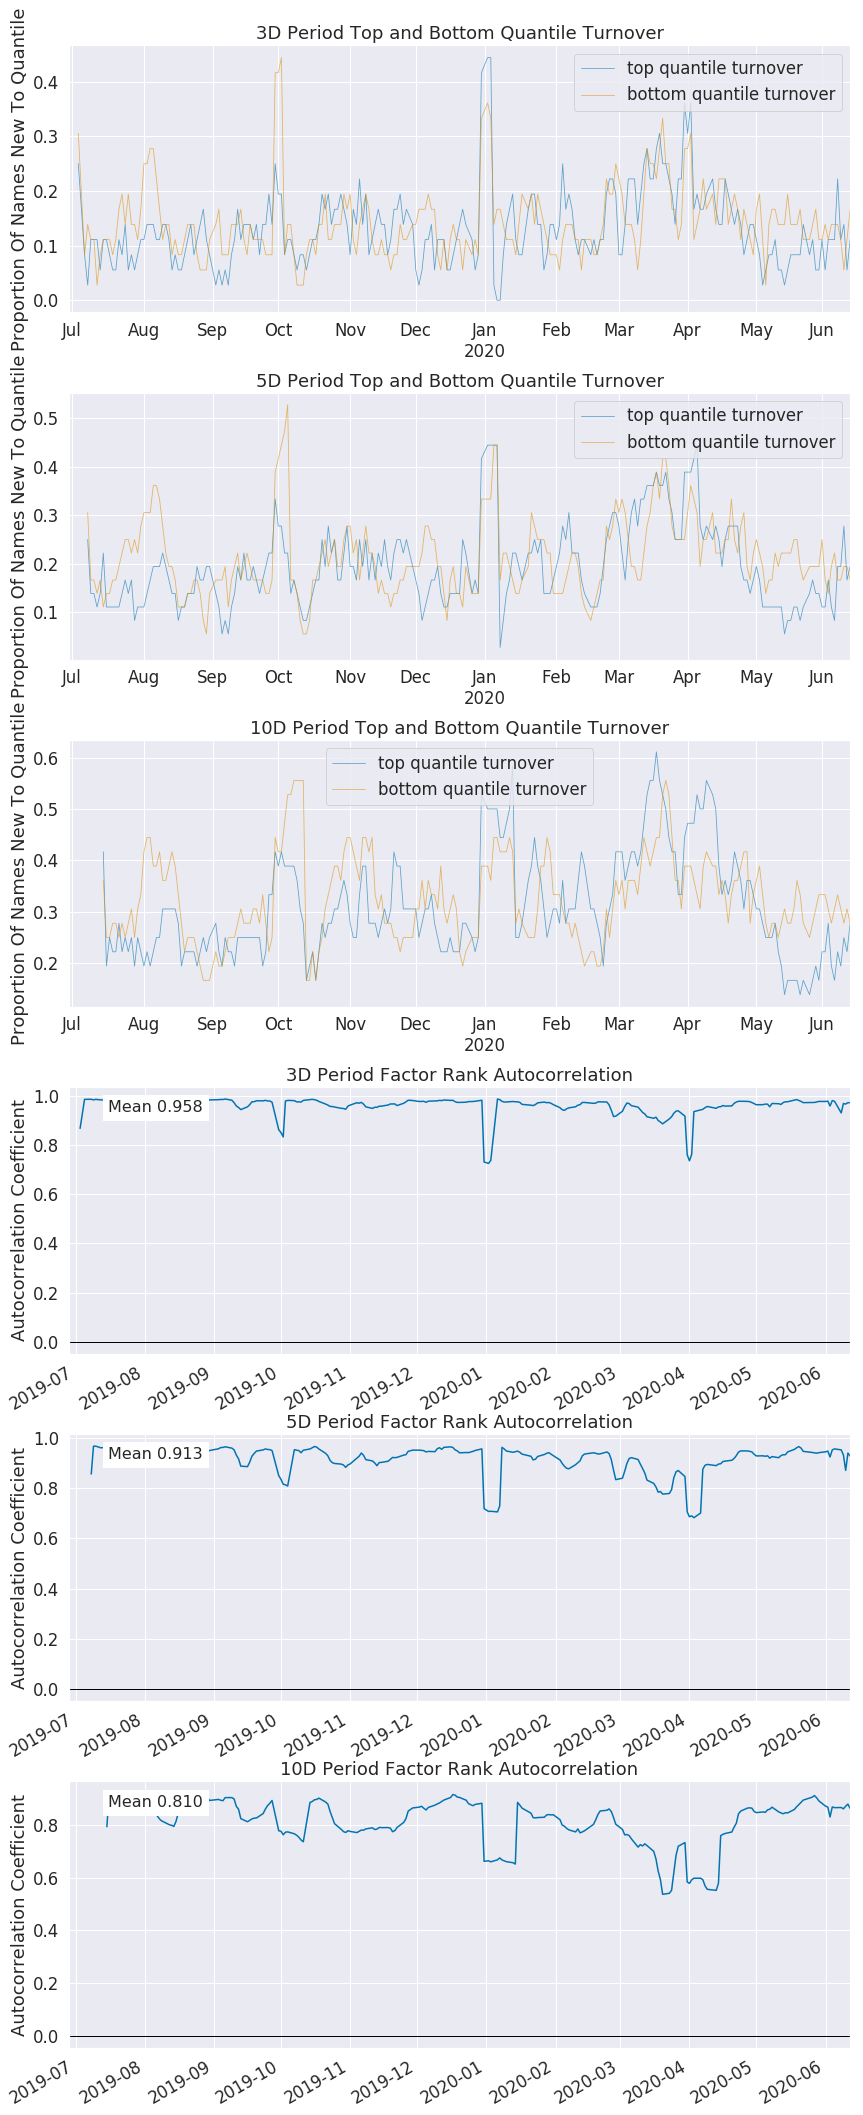

In [103]:
al.tears.create_full_tear_sheet(factor_data, by_group=True, long_short=True, group_neutral=False);

In [104]:
ic = al.performance.mean_information_coefficient(factor_data, group_adjust=False, by_group=False, by_time=None)
ic['5D']

0.08060086344180814

In [105]:
alpha_betha = al.performance.factor_alpha_beta(factor_data, returns=None, demeaned=True, group_adjust=False, equal_weight=False)

In [106]:
alpha_betha['5D']

Ann. alpha    0.564672
beta          0.087917
Name: 5D, dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



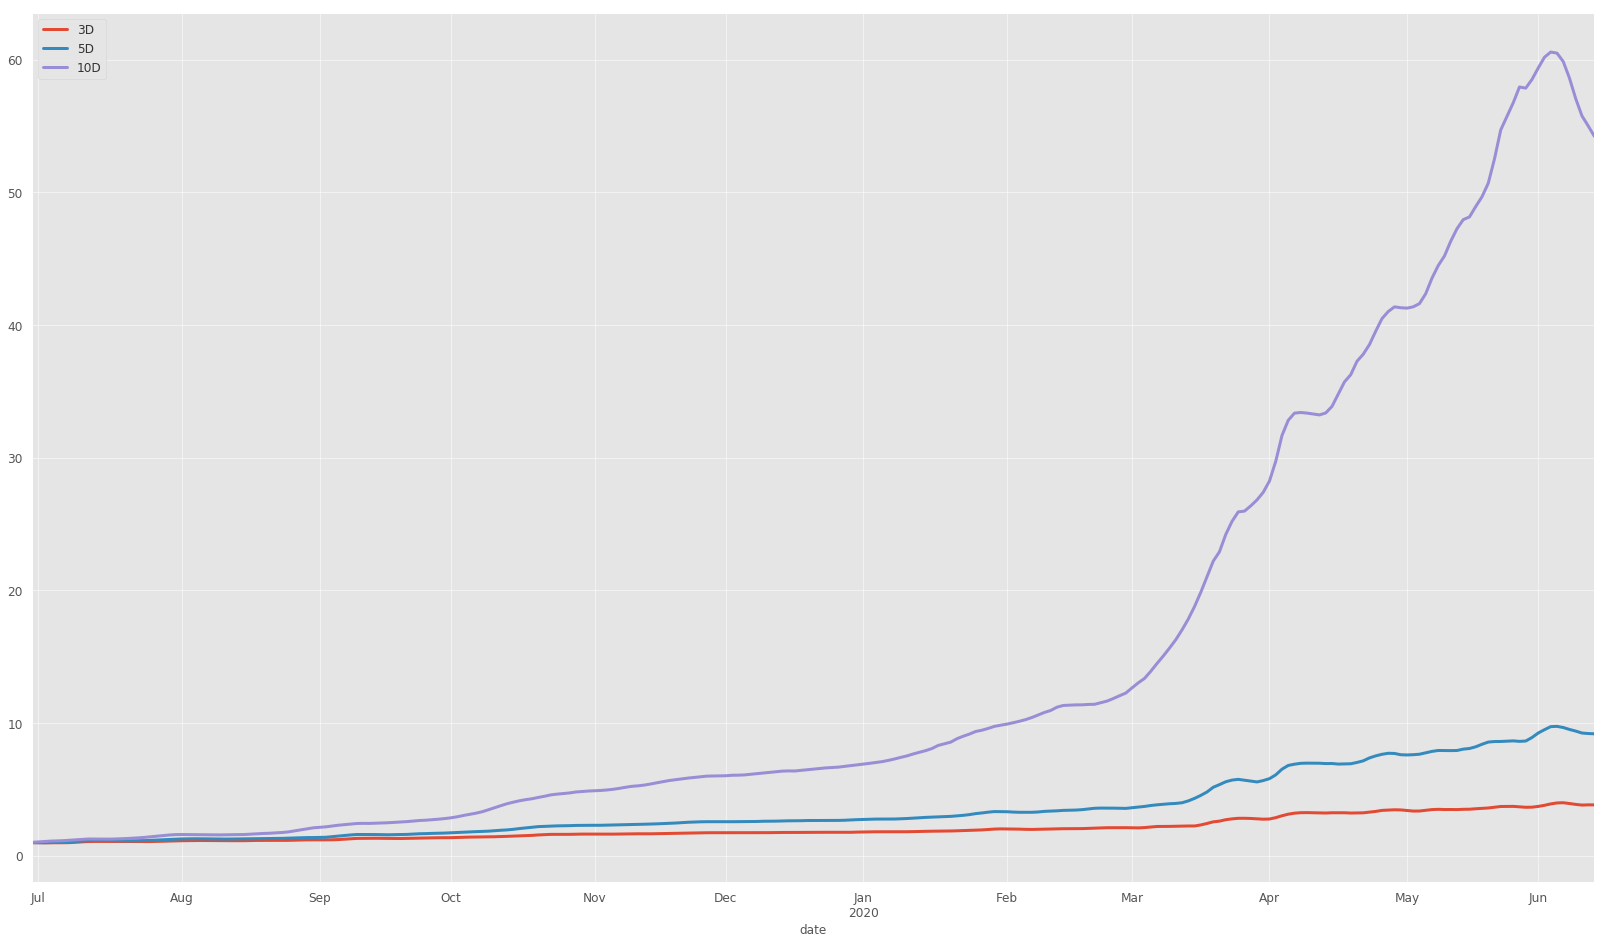

In [107]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (28, 16)

ls_factor_returns = al.performance.factor_returns(factor_data)

(1+ls_factor_returns).cumprod().plot(lw=3);

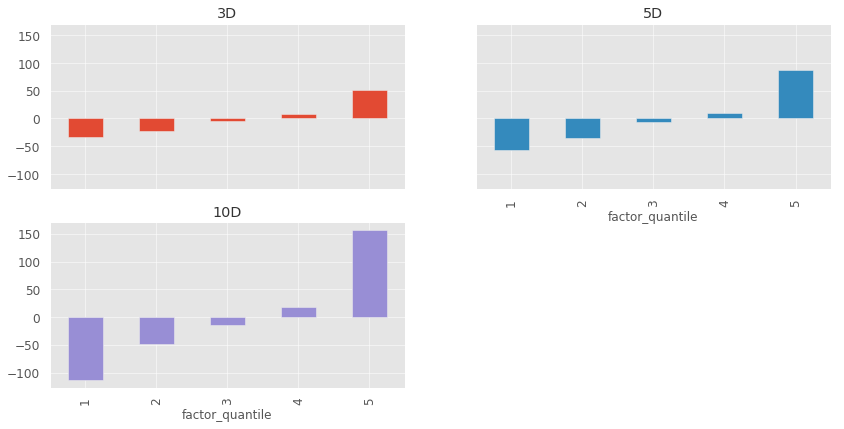

In [108]:
qr_factor_returns = pd.DataFrame()

qr_factor_returns = al.performance.mean_return_by_quantile(factor_data)[0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

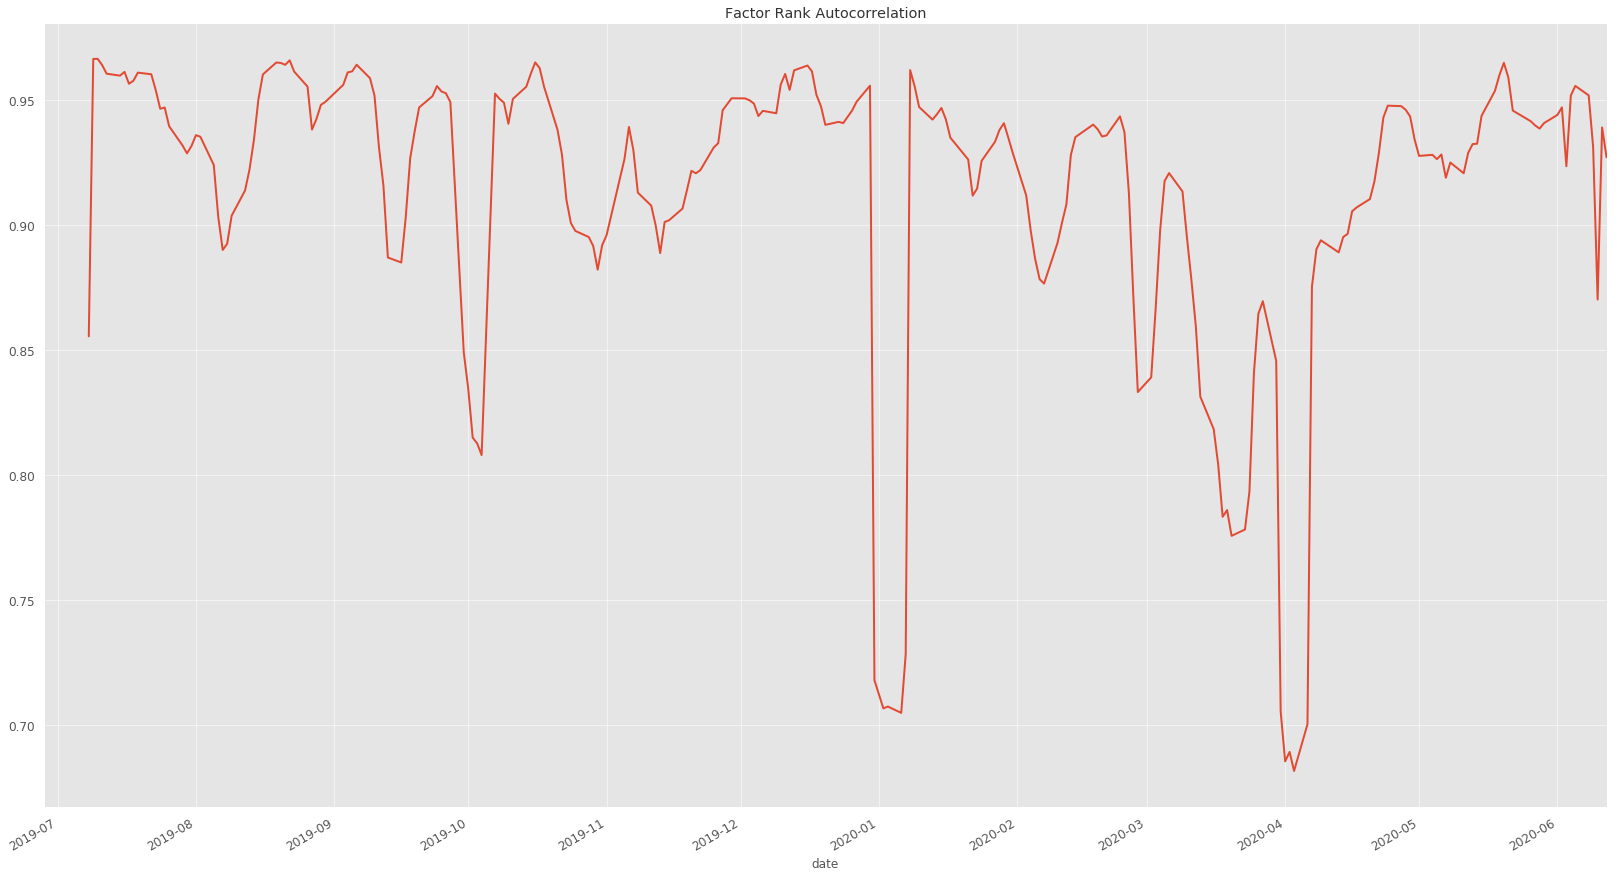

In [109]:
ls_FRA = pd.DataFrame()
ls_FRA = al.performance.factor_rank_autocorrelation(factor_data, period = rebalance_period)
ls_FRA.plot(title="Factor Rank Autocorrelation",lw=2);

In [110]:
ls_FRA.mean()

0.9130822524995882

In [111]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

3D      8.73
5D     11.20
10D    18.17
dtype: float64

# 10 - Predicted Portfolio

In [112]:
optimal_weights_regularized = optimal.iloc[-1]

for 180 assets  with end date: 2020-06-26 00:00:00+00:00


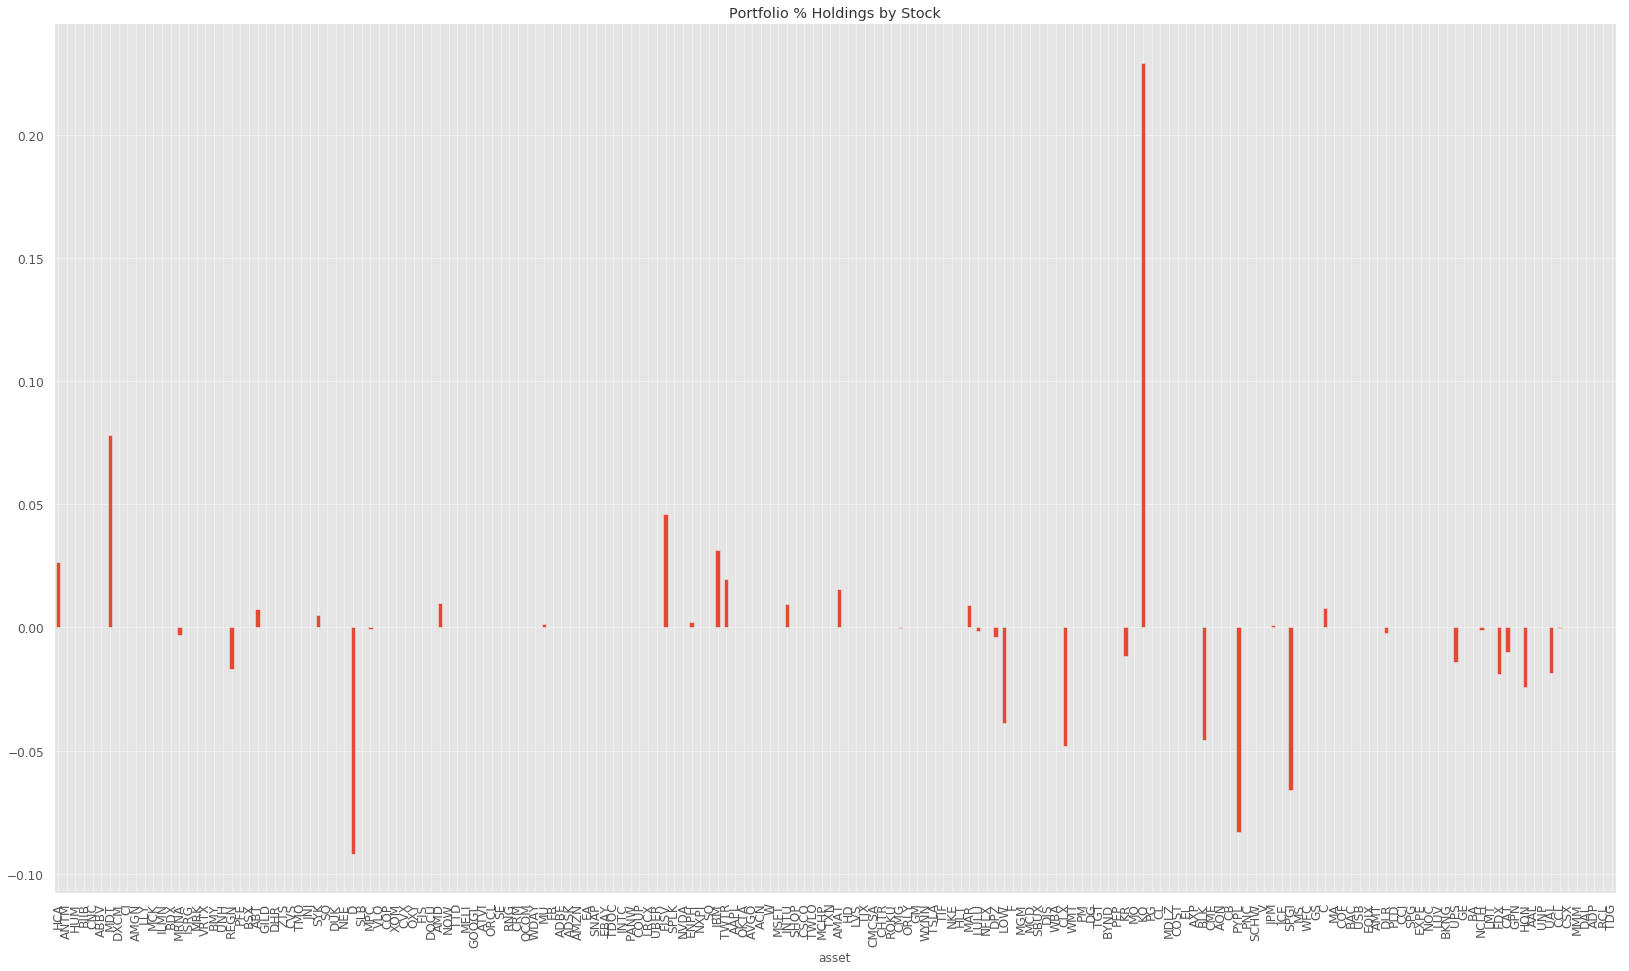

In [113]:
print ('for {} assets  with end date: {}'.format(len(optimal_weights_regularized.index),optimal.index[-1]))
optimal_weights_regularized.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.grid(alpha=0.8)

In [114]:
optimal_weights_regularized = pd.DataFrame(data = optimal_weights_regularized.values, 
                                           columns = ['optimal_weights'],
                                           index = optimal_weights_regularized.index)
optimal_weights_regularized.index.name = 'asset'

In [115]:
q5 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=False)[:len(optimal_weights_regularized.index)//5]
q1 = optimal_weights_regularized.sort_values(by='optimal_weights',ascending=True)[:len(optimal_weights_regularized.index)//5]

In [116]:
print (q5.iloc[0])
print (q1.iloc[0])

optimal_weights    0.229179
Name: KO, dtype: float64
optimal_weights   -0.09175
Name: D, dtype: float64


In [117]:
assert np.round(optimal_weights_regularized.sum(),2)[0] == 0.0

## 10 - 3 - Risk analysis with optimized weights

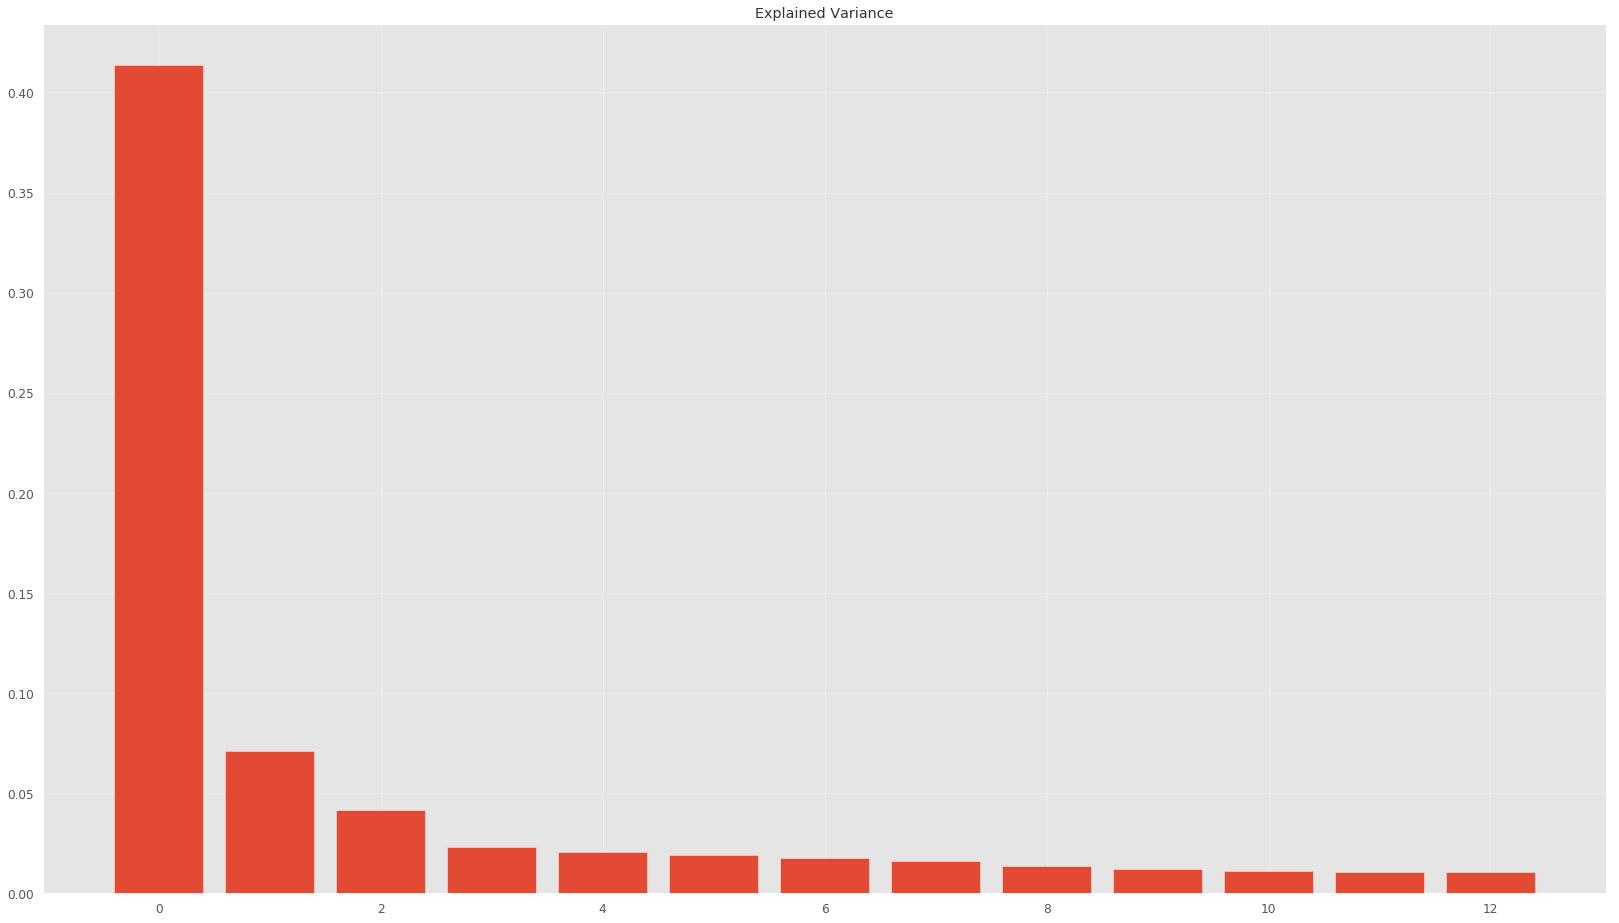

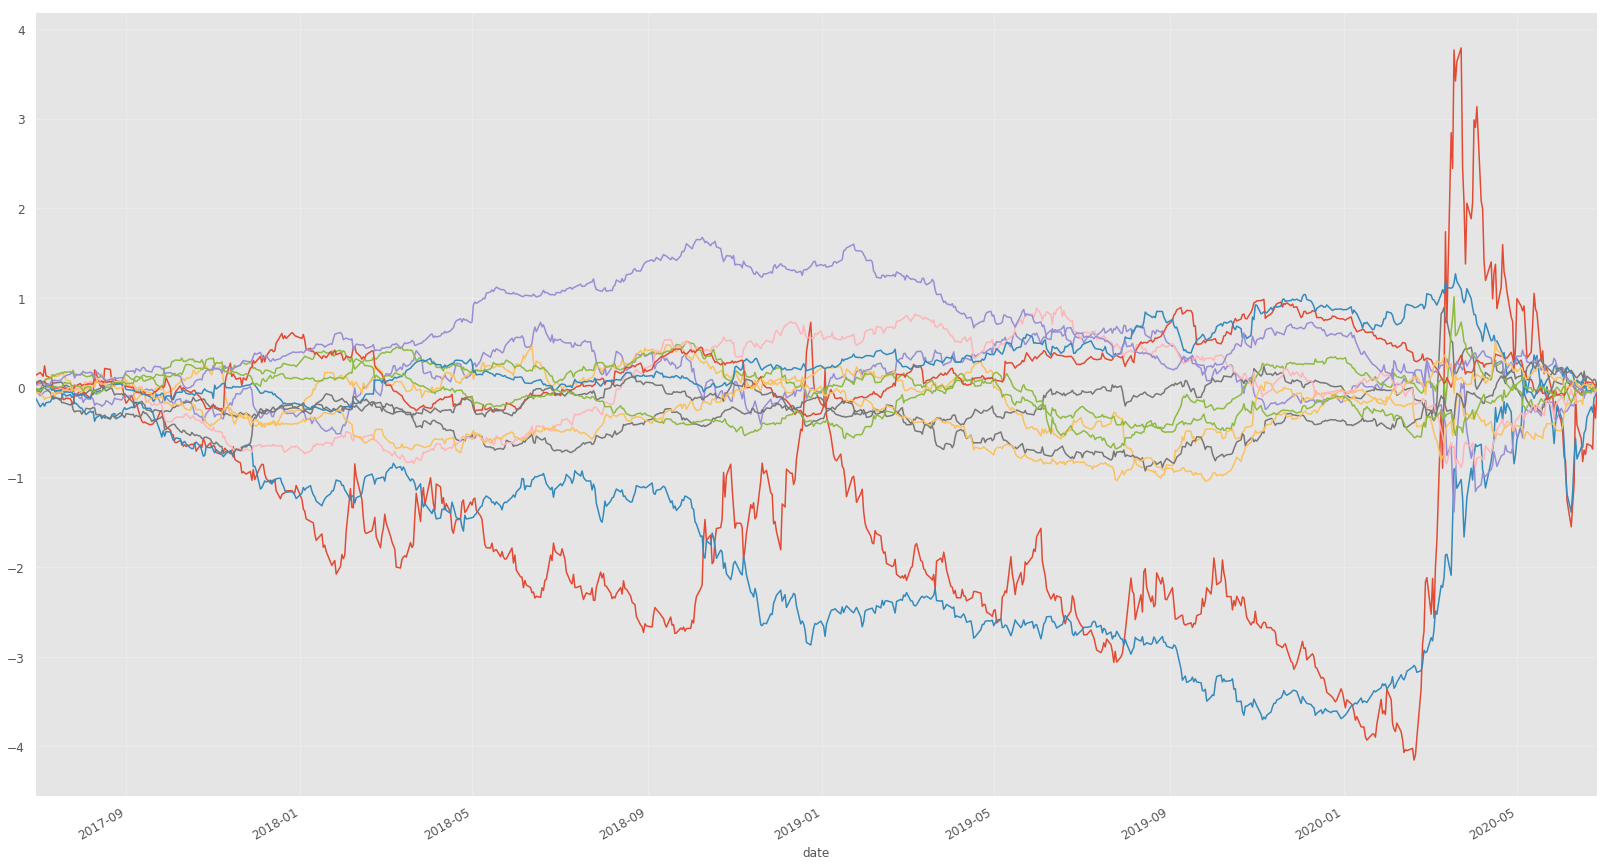

In [118]:
predicted_portfolio_risk,Risk_Model = risk_model.portfolio_risk(close[optimal_weights_regularized.index],num_factor_exposures=factor_exposures,weights=optimal_weights_regularized)

In [119]:
assert np.round(predicted_portfolio_risk,2) == risk_cap

In [120]:
print ('Predicted Risk: {} %'.format(np.round((predicted_portfolio_risk*100),2)))

Predicted Risk: 5.0 %


In [121]:
all_factors.to_csv('all_factors.csv')
optimal_weights_regularized.to_csv('optimal_weights_regularized.csv')
close.to_csv('close.csv')